In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from scipy.signal import correlate
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d
import h5py
from scipy.stats import pearsonr

In [2]:
# Plot style parameters
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=20)          # text size
plt.rc('axes', titlesize=24)     # axes title size
plt.rc('axes', labelsize=24)     # axes label size
plt.rc('xtick', labelsize=24)    # x-tick label size
plt.rc('ytick', labelsize=24)    # y-tick label size
plt.rc('legend', fontsize=24)    # legend font size
plt.rc('figure', titlesize=24)   # figure title size

In [3]:
def extract_data(folder):
    data_dict = {}

    for filename in os.listdir(folder):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder, filename)
            file_key = os.path.splitext(filename)[0]

            try:
                # Try loading with scipy.io (for most MATLAB files)
                mat_data = sio.loadmat(file_path)
                clean_data = {k: v for k, v in mat_data.items() if not k.startswith('__')}

            except NotImplementedError:
                # If it's a v7.3 (HDF5-based) file, use h5py
                with h5py.File(file_path, 'r') as f:
                    clean_data = {}
                    def recursively_load(name, obj):
                        if isinstance(obj, h5py.Dataset):
                            clean_data[name] = np.array(obj)
                    f.visititems(recursively_load)

            # Extract 'dataArray' key from file structure
            if 'dataArray' in clean_data:
                arr = clean_data['dataArray']
                if arr.ndim == 2 and arr.shape[1] >= 2:
                    HN_data = arr[:, 0]
                    WL_data = arr[:, 1]

                    data_dict[f'{file_key}_HN_data'] = HN_data
                    data_dict[f'{file_key}_WL_data'] = WL_data

            # Metadata stored here in case it is needed later
            meta = {}
            for key in ['runTime', 'xCenCorrection', 'xLinear', 'xLinearStage']:
                if key in clean_data:
                    meta[key] = clean_data[key]
            data_dict[f'{file_key}_meta'] = meta

    return data_dict

In [4]:
def nfft(a, axis=0):
    '''Numpy equivalent of MATLAB's ifftshift(fft(fftshift(a)))'''
    return np.fft.ifftshift(np.fft.fft(np.fft.fftshift(a, axes=axis), axis=axis), axes=axis)


def nifft(a, axis=0):
    '''Numpy equivalent of MATLAB's fftshift(ifft(ifftshift(a)))'''
    return np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(a, axes=axis), axis=axis), axes=axis)


def smooth(data, window_size):
    '''Simple moving average smoothing'''
    return uniform_filter1d(data, size=window_size, mode='nearest')

In [5]:
def calibrateDelayAxis(v, xL):
    '''
    Calibrate the delay axis using knowledge of the HeNe wavelength.
    Taken from dataProcessing code in MatLab (absolutely disgusting). 
    
    Params:
    -----------
    v: HeNe voltage/intensity signal
    xL: Linear x-grid (delay axis)
    
    Outputs:
    --------
    xNL: Nonlinear corrected x-grid
    '''
    # HeNe wavelength in mm
    lambdaHeNe = 0.6328/1000  # 632.8 nm converted to mm
    
    # Angular wave number
    k = 2*np.pi/lambdaHeNe
    
    # Step size
    dx_mm = np.mean(np.diff(xL))
    
    # Number of points in the grid
    N = len(xL)
    
    # Spatial frequency grid
    # Step size in frequency domain
    dfx = 1/(dx_mm*N)
    
    # Maximum extent
    fxMax = 1/dx_mm
    
    # Frequency grid
    fx = np.arange(-fxMax/2, fxMax/2, dfx)
    
    # Ensure fx and v have the same length
    if len(fx) > N:
        fx = fx[:N]
    elif len(fx) < N:
        fx = np.linspace(-fxMax/2, fxMax/2, N)
    
    # Take the Fourier transform of the voltage array
    V = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(v)))
    
    # The AC peak is located near
    p0 = 1/lambdaHeNe
    
    # Find the nearest pixel to this location
    idx = np.argmin(np.abs(p0 - fx))
    idx0 = np.argmin(np.abs(fx))
    
    # Construct a super-Gaussian filter
    # Super-Gaussian order
    n = 22
    
    # Half-width
    sigma = (idx - (N/2 + 1))*dfx*0.25
    
    # Filter
    G = np.exp(-((fx - fx[idx])**n)/(sigma**n))
    
    # Multiply by the filter and circshift to the center
    V = np.roll(G*V, -(idx - idx0))
    
    # Inverse Fourier transform
    v2 = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(V)))
    
    # Extract the phase and unwrap
    phi = np.unwrap(np.angle(v2))
    
    # Solve for the position dependent correction
    delta_x = phi/k
    
    # Add these deltas back to the original x-grid
    xNL = xL + delta_x
    
    return xNL

In [6]:
def removeLinearTerm(w, phase):
    '''Remove linear term from phase using polynomial fit'''
    idx = ~np.isnan(phase)
    if np.sum(idx) < 2:
        return phase
    
    nanPhase = phase[idx]
    nanW = w[idx]
    
    # Fit linear polynomial
    p = np.polyfit(nanW, nanPhase, 1)
    phase = phase - p[0]*w - p[1]
    
    return phase

def calculateZeroDelayCorrection(w, dw, xL, wl_data):
    '''Calculate zero delay correction from white light data'''
    wlSpec = nfft(wl_data - np.median(wl_data))
    wlSpec[w < 0] = 0
    
    # Calculate center of mass in frequency domain
    wCen = np.sum(w*np.abs(wlSpec)**2)/np.sum(np.abs(wlSpec)**2)
    wCenPx = int(np.round(wCen/dw))
    wlSpec = np.roll(wlSpec, -wCenPx)
    
    wlTemp = smooth(np.abs(nifft(smooth(wlSpec, 5)))**2, 5)
    
    xCen = np.sum(xL*wlTemp)/np.sum(wlTemp)
    
    return xCen, wlSpec

In [7]:
def WLI_processData(dataArray, xL, start_idx=None, end_idx=None):
    '''    
    Params:
    -----------
    dataArray: 2D array with columns [HeNe, WhiteLight]
    xL: Linear delay axis
    start_idx, end_idx: Optional indices to slice the data
    
    Outputs:
    --------
    xCen: Zero delay correction
    spectrum: Processed spectrum (HeNe and WL)
    wLPhase: Unwrapped white light phase
    lambda_vals: Wavelength array
    '''
    
    # Slice data if indices provided
    if start_idx is not None and end_idx is not None:
        dataArray = dataArray[start_idx:end_idx, :]
        xL = xL[start_idx:end_idx]
    
    N = len(dataArray)
    heneData = dataArray[:, 0]
    
    # Calibrate delay axis (simplified - keeping linear for now)
    xNL = calibrateDelayAxis(heneData, xL)
    
    # Interpolate data onto calibrated axis
    f_hene = interp1d(xNL, heneData, kind='cubic', fill_value=0, bounds_error=False)
    f_wl = interp1d(xNL, dataArray[:, 1], kind='cubic', fill_value=0, bounds_error=False)
    dataArray_interp = np.column_stack([f_hene(xL), f_wl(xL)])
    
    # Calculate frequency axis
    c_mm_ps = 0.3  # Speed of light, mm/ps
    t = 2*xL/c_mm_ps
    dw = 2*np.pi/(np.max(np.abs(t)) - np.min(np.abs(t)))
    wMax = dw * N
    w = np.arange(-wMax/2, wMax/2, dw)
    
    # Ensure w and data have same length
    if len(w) > N:
        w = w[:N]
    elif len(w) < N:
        # Pad or trim as needed
        w = np.linspace(-wMax/2, wMax/2, N)
    
    # Convert to wavelength (in microns)
    lambda_vals = (2*np.pi*c_mm_ps/w)*1000
    idx = (lambda_vals > 0.2) & (lambda_vals < 1.5)
    lambda_vals = lambda_vals[idx]
    w_selected = w[idx]
    
    # Calculate zero delay correction
    xCen = calculateZeroDelayCorrection(w, dw, xL, dataArray_interp[:, 1])[0]
    
    # Process field - subtract baseline
    # Use median subtraction like MATLAB: dataArray(256,:) for reference point
    ref_idx = N//4  # Integer division; 256 for N=1024
    field = dataArray_interp - dataArray_interp[ref_idx, :]
    field[field < -0.03] = 0
    field = nfft(field, axis=0)
    
    # Calculate spectrum
    spectrum = np.abs(field)**2
    
    # Extract white light phase from selected frequency range
    wLPhase = np.unwrap(np.angle(field[idx, 1]))
    
    # Smooth and normalize spectrum in selected range
    spectrum = spectrum[idx, :]
    spectrum[:, 0] = smooth(spectrum[:, 0], 5)
    
    # Normalize each column independently
    for col in range(spectrum.shape[1]):
        spec_min = np.min(spectrum[:, col])
        spec_max = np.max(spectrum[:, col])
        if spec_max > spec_min:
            spectrum[:, col] = (spectrum[:, col] - spec_min)/(spec_max - spec_min)
    
    # Mask low-intensity regions in phase (blank where WL spectrum is weak)
    phaseBlank = spectrum[:, 1] < 0.1
    wLPhase[phaseBlank] = np.nan
    
    # Remove linear term from phase using frequency axis
    wLPhase = removeLinearTerm(w_selected, wLPhase)
    
    # Smooth phase (only non-NaN values)
    valid_idx = ~np.isnan(wLPhase)
    if np.sum(valid_idx) > 5:
        wLPhase_smooth = wLPhase.copy()
        wLPhase_smooth[valid_idx] = smooth(wLPhase[valid_idx], 5)
        wLPhase = wLPhase_smooth
    
    return xCen, spectrum, wLPhase, lambda_vals, w_selected

In [9]:
def fit_phase_polynomial(lambda_vals, phase, degree=2):
    '''
    Params:
    -----------
    lambda_vals: Wavelength array
    phase: Phase array (may contain NaNs)
    degree: Polynomial degree (default=2 for quadratic)
    
    Outputs:
    --------
    coeffs: Polynomial coefficients
    phase_fit: Fitted phase values
    lambda_cont: Wavelength values only in continuous region
    phase_cont: phase values only in continuous region
    '''
    # Removes NaN values
    valid_idx = ~np.isnan(phase)
    
    if np.sum(valid_idx) < degree + 1:
        return None, None
        
    # Find continuous valid region   
    valid_positions = np.where(valid_idx)[0]
    start_idx = valid_positions[0]
    end_idx = valid_positions[-1]+1

    # Extract continuous region
    lambda_cont = lambda_vals[start_idx:end_idx]
    phase_cont = phase[start_idx:end_idx]

    # Sort by wavelength in ascending order
    sort_idx = np.argsort(lambda_cont)
    lambda_cont = lambda_cont[sort_idx]

    # Only fit not NaN points in region
    valid_in = ~np.isnan(phase_cont)

    if np.sum(valid_in)<degree+1:
        return None, None, None, None
    
    # Polynomial fit for phase
    coeffs = np.polyfit(lambda_cont[valid_in], phase_cont[valid_in], degree)
    
    # Evaluate polynomial
    phase_fit = np.polyval(coeffs, lambda_cont)
    
    return coeffs, phase_fit, lambda_cont, phase_cont


In [10]:
def plot_spectrum_and_phase(lambda_vals, spectrum, phase, phase_fit=None, lambda_trim=None, phase_trim=None, title='WLI Data', save_fig=False, 
                            output_dir=None, filename=None):
    '''    
    Params:
    -----------
    lambda_vals: Wavelength array in microns
    spectrum: Spectrum array (2 columns: HeNe, WL)
    phase: Phase array
    phase_fit: Fitted phase
    lambda_trim: Wavelength array for fit
    phase_trim: Phase data in continuous region
    title: Plot title
    '''
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Plot Spectrum, left axis
    ax1.set_xlabel(r'$\lambda [\mu m]$', fontweight='bold')
    ax1.set_ylabel('Spectrum [a.u.]', fontweight='bold')
    ax1.plot(lambda_vals, spectrum[:, 0], label='HeNe', color='red', alpha=0.8)
    ax1.plot(lambda_vals, spectrum[:, 1], label='WL', color='black', alpha=0.8)
    ax1.tick_params(axis='y')
    ax1.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    ax1.grid(True, alpha=0.4)
    
    # Plot phase on right axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Phase [rad]', fontweight='bold')

    # Will plot trimmed phase is there is one, otherwise full phase
    if phase_trim is not None and lambda_trim is not None:
        ax2.plot(lambda_trim, phase_trim, 'o-', label='Phase', color='darkorange', markersize=5, alpha=0.8)
    else:
        ax2.plot(lambda_vals, phase, 'o-', label='Phase', color='darkorange', markersize=5, alpha=0.8)

    if phase_fit is not None and lambda_trim is not None:
        ax2.plot(lambda_trim, phase_fit, '--', label='Phase Fit', color='green', linewidth=2)
    
    
    ax2.tick_params(axis='y')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')
    
    plt.title(title, fontweight='bold')
    plt.tight_layout()

    if save_fig and output_dir and filename:
        filepath = os.path.join(output_dir, f'{filename}.pdf')
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f'  Saved: {filename}.pdf')
        
    
    return fig, (ax1, ax2)

In [11]:
def plot_diagnostic(dataArray, xL, field_fft, w, lambda_vals, title="Diagnostic Plot"):
    '''
    Create diagnostic plots to understand the FFT and phase extraction
    
    Params:
    -----------
    dataArray: Original data array
    xL: Position axis
    field_fft: FFT of the field
    w: Angular frequency array
    lambda_vals: Wavelength array
    title: Plot title
    '''
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Raw data in spatial domain
    axes[0, 0].plot(xL, dataArray[:, 0], label='HeNe', color='red', alpha=0.7)
    axes[0, 0].plot(xL, dataArray[:, 1], label='WL', color='black', alpha=0.7)
    axes[0, 0].set_xlabel('Position [mm]', fontweight='bold')
    axes[0, 0].set_ylabel('Intensity', fontweight='bold')
    axes[0, 0].set_title('Raw Interferogram', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Spectrum in frequency domain (positive frequencies)
    pos_idx = w > 0
    freq_lambda = (2*np.pi*0.3/w[pos_idx])*1000  # Convert to wavelength
    valid_lambda = (freq_lambda > 0.2) & (freq_lambda < 2.0)
    
    axes[0, 1].plot(freq_lambda[valid_lambda], np.abs(field_fft[pos_idx, 0][valid_lambda])**2, 
                    label='HeNe', color='red', alpha=0.7)
    axes[0, 1].plot(freq_lambda[valid_lambda], np.abs(field_fft[pos_idx, 1][valid_lambda])**2, 
                    label='WL', color='black', alpha=0.7)
    axes[0, 1].set_xlabel(r'$\lambda [\mu m]$', fontweight='bold')
    axes[0, 1].set_ylabel('Power Spectrum', fontweight='bold')
    axes[0, 1].set_title('FFT Magnitude', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([0.4, 1.2])
    
    # Plot 3: Raw (wrapped) phase
    axes[1, 0].plot(freq_lambda[valid_lambda], np.angle(field_fft[pos_idx, 1][valid_lambda]), 
                    'o', markersize=2, color='blue', alpha=0.6)
    axes[1, 0].set_xlabel(r'$\lambda [\mu m]$', fontweight='bold')
    axes[1, 0].set_ylabel('Phase [rad]', fontweight='bold')
    axes[1, 0].set_title('Raw Phase (Wrapped)', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_xlim([0.4, 1.2])
     
    # Plot 4: Unwrapped phase
    unwrapped_phase = np.unwrap(np.angle(field_fft[pos_idx, 1][valid_lambda]))
    axes[1, 1].plot(freq_lambda[valid_lambda], unwrapped_phase, 
                    'o', markersize=2, color='green', alpha=0.6)
    axes[1, 1].set_xlabel(r'$\lambda [\mu m]$', fontweight='bold')
    axes[1, 1].set_ylabel('Phase [rad]', fontweight='bold')
    axes[1, 1].set_title('Unwrapped Phase', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim([0.4, 1.2])
    
    plt.suptitle(title, fontweight='bold')
    plt.tight_layout()
    
    return fig

In [12]:
def plot_diagnostic(dataArray, xL, title="Interferogram", save_fig=False, output_dir=None, filename=None):
    '''
    Repurposed diagnostic plots function fro raw interferogram.
    
    Params:
    -----------
    dataArray: Original data array
    xL: Position axis
    title: Plot title
    '''
    
    fig = plt.figure(figsize=(12,8))
    plt.plot(xL, dataArray[:,0], label='HeNe', color='red', alpha=0.7)
    plt.plot(xL, dataArray[:,1], label='WL', color='black', alpha=0.7)
    plt.xlabel('Position [mm]', fontweight='bold')
    plt.ylabel('Intensity', fontweight='bold')
    plt.title(f'{title}', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig

In [13]:
#%ls ..\Team32025\WLI_establish_20251015

Processing data from index 700 to 1800
Found 25 datasets

Processing: raw_data_001_20251015


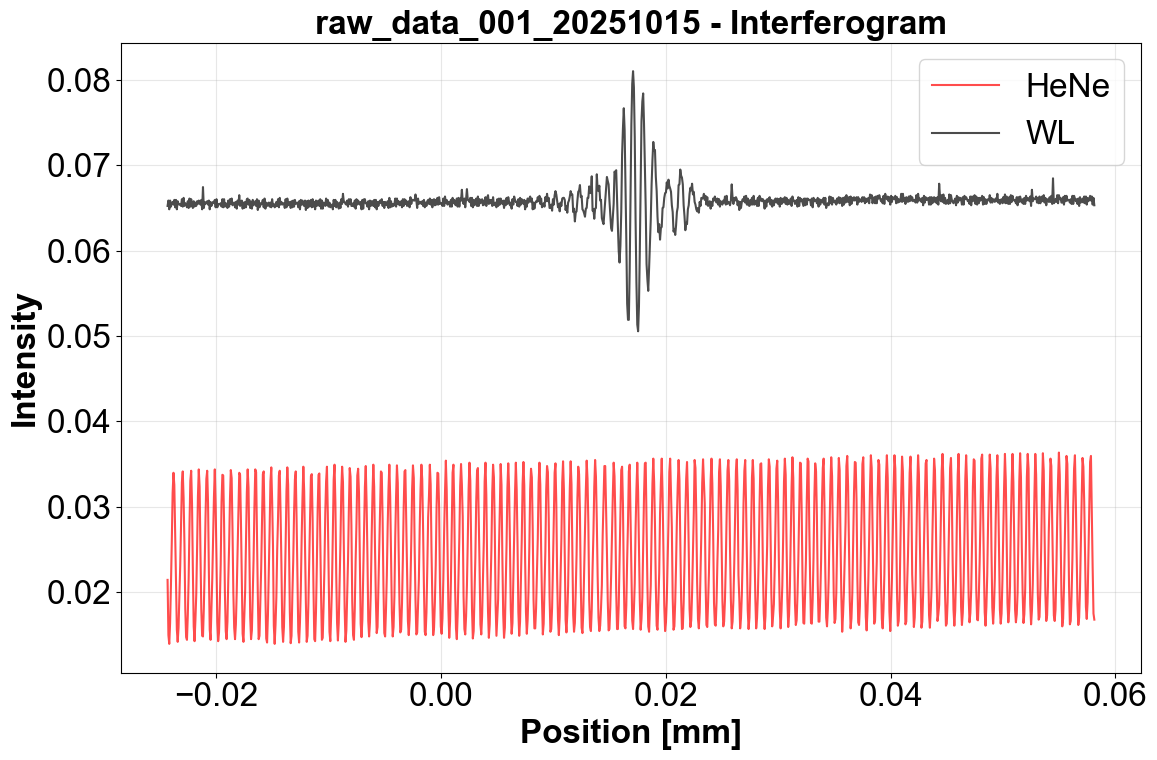

Zero delay correction: 0.021266
Polynomial coefficients: [ 15.59524245 -35.07885673  19.32276885]
Fit domain $\lambda$ = 0.874 to 1.435 $\mu m$


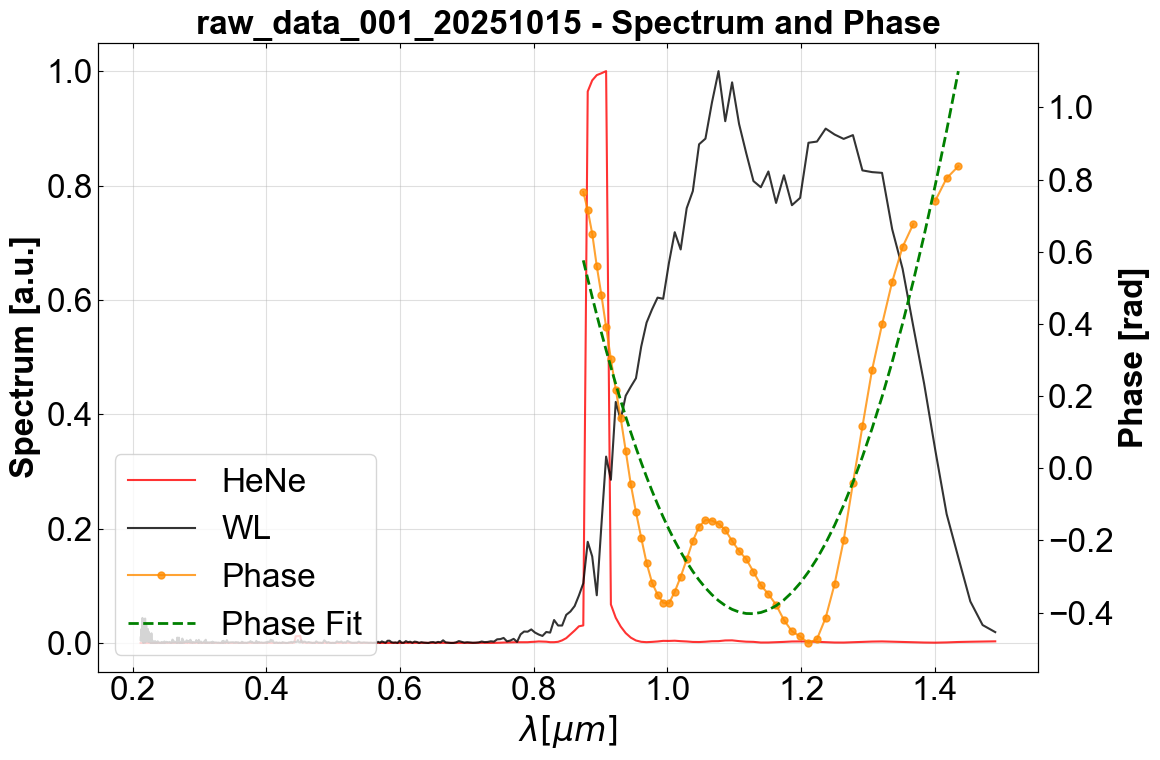


Processing: raw_data_002_20251015


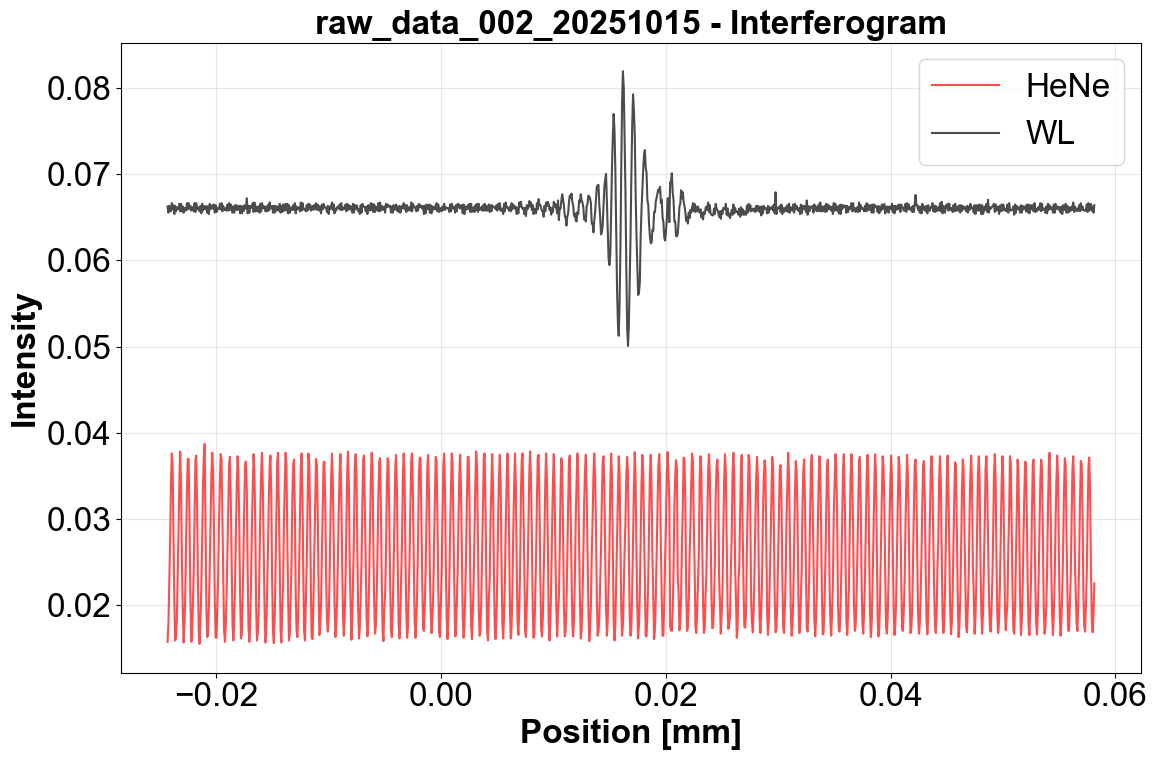

Zero delay correction: 0.025052
Polynomial coefficients: [ 14.05073195 -31.89744774  17.72782143]
Fit domain $\lambda$ = 0.881 to 1.453 $\mu m$


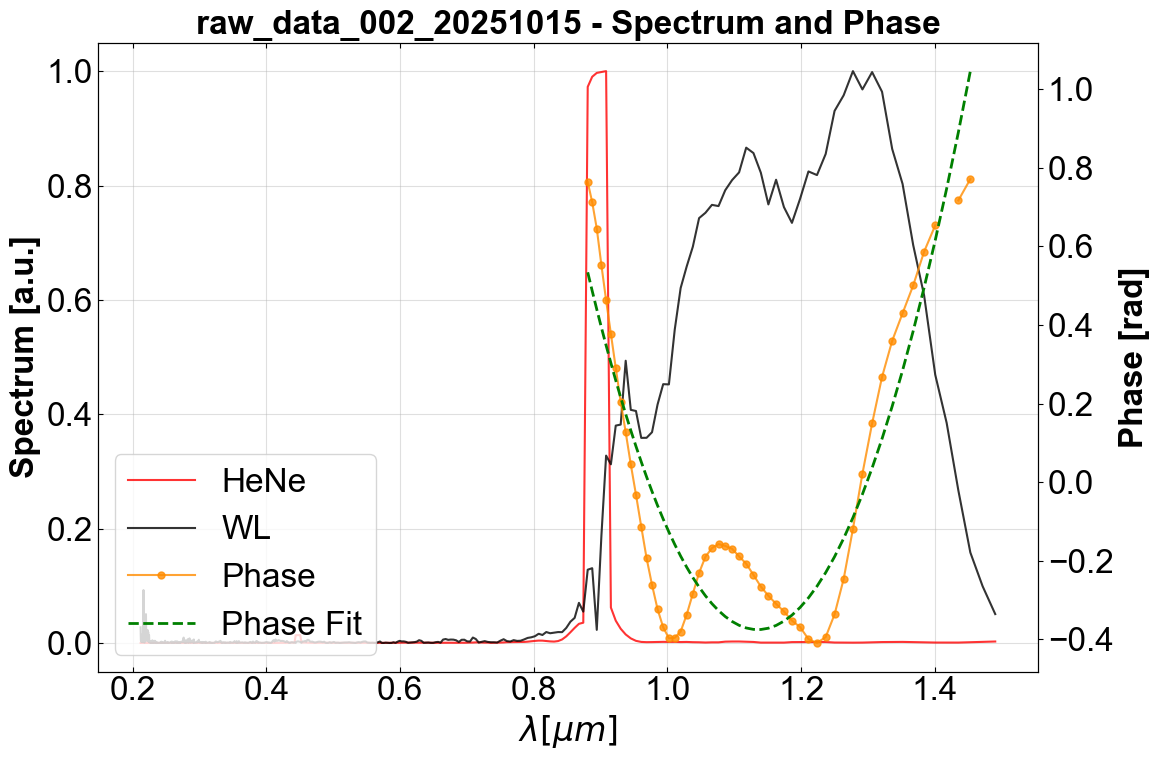


Processing: raw_data_003_20251015


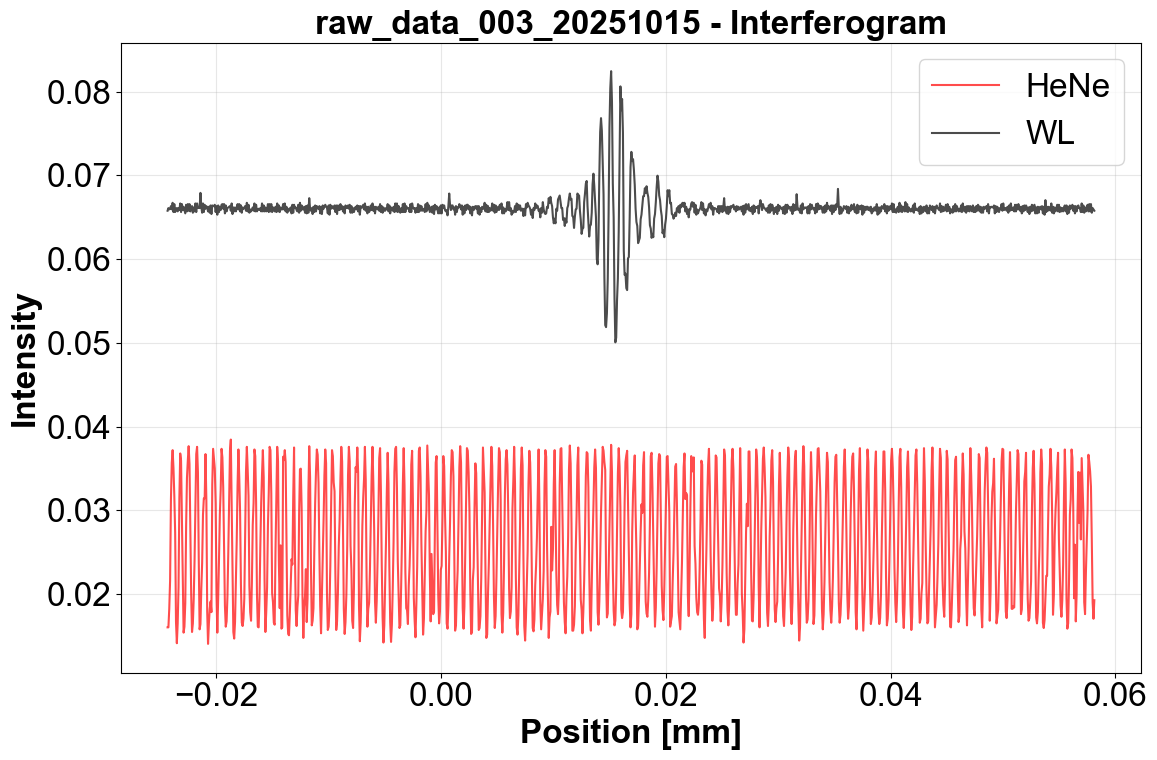

Zero delay correction: 0.024973
Polynomial coefficients: [ 12.47970737 -28.93119184  16.38288821]
Fit domain $\lambda$ = 0.887 to 1.490 $\mu m$


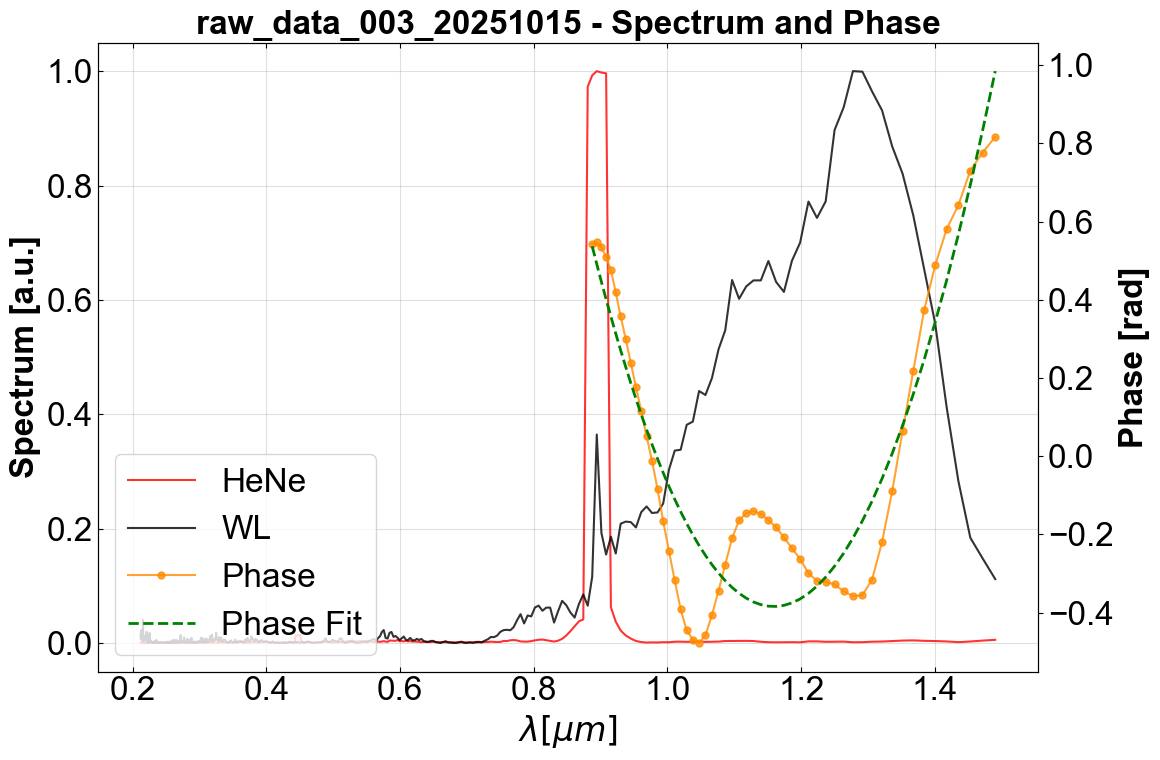


Processing: raw_data_004_20251015


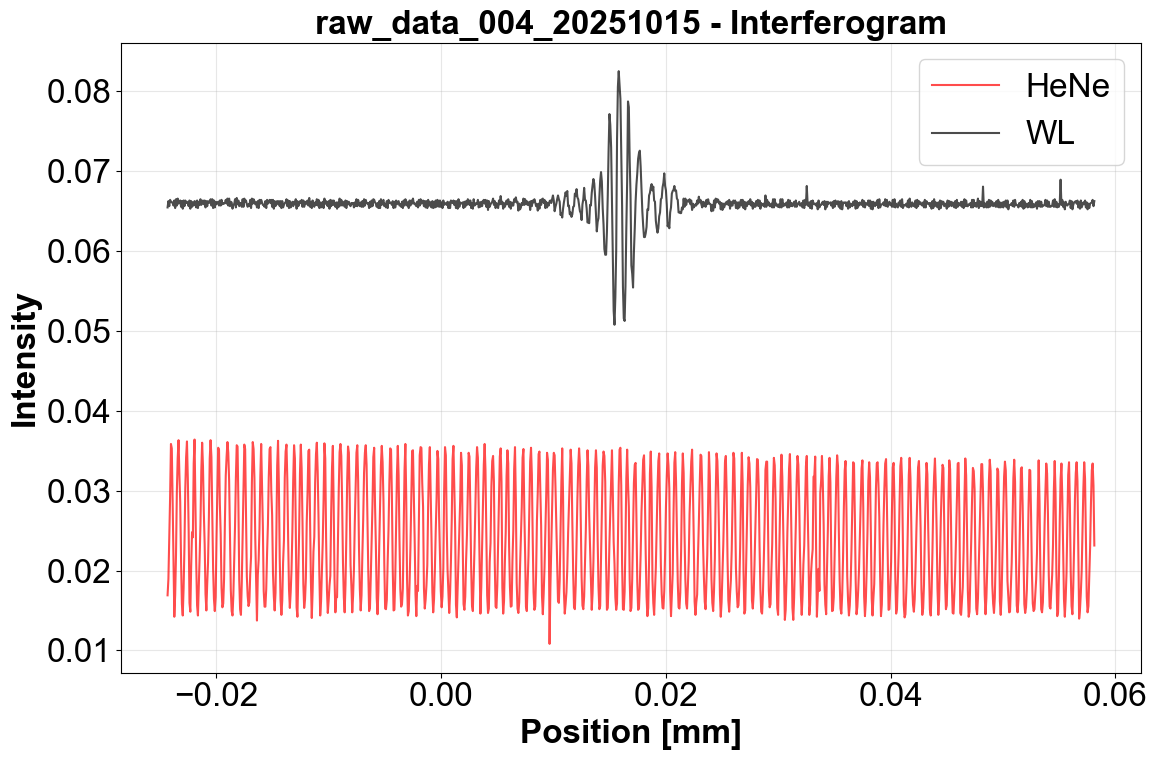

Zero delay correction: 0.021116
Polynomial coefficients: [ 15.84567972 -35.702053    19.75968961]
Fit domain $\lambda$ = 0.894 to 1.401 $\mu m$


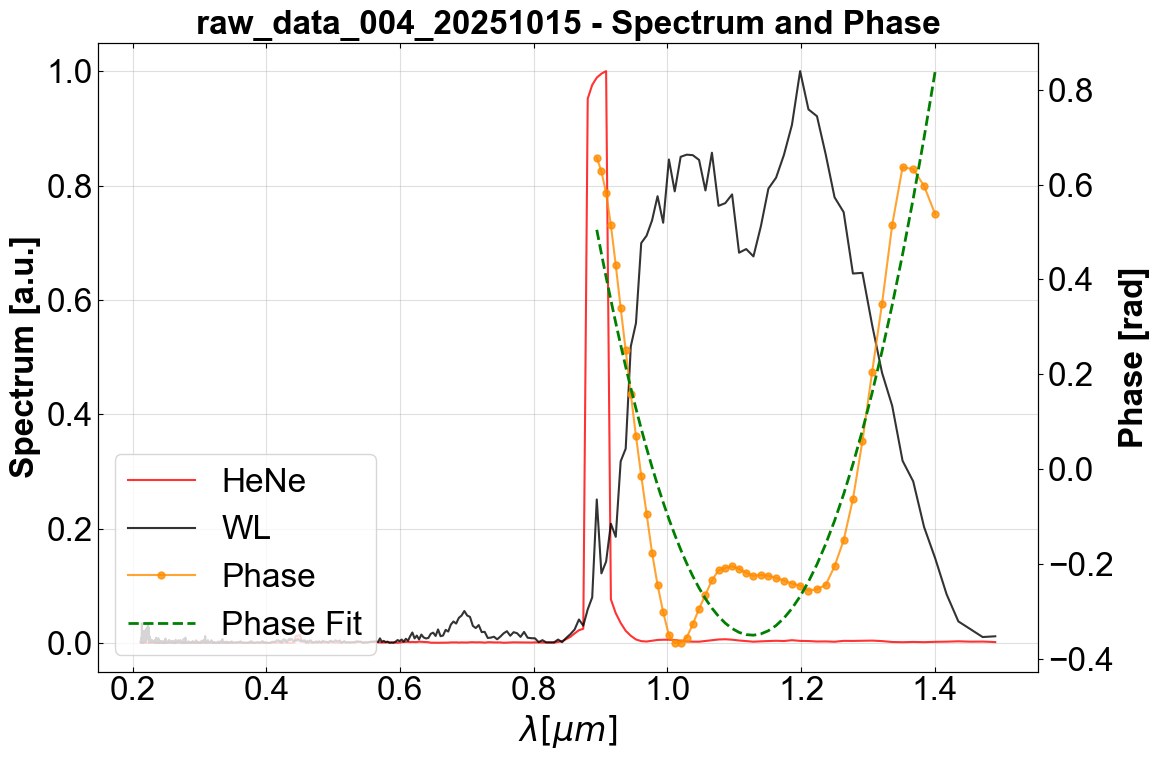


Processing: raw_data_005_20251015


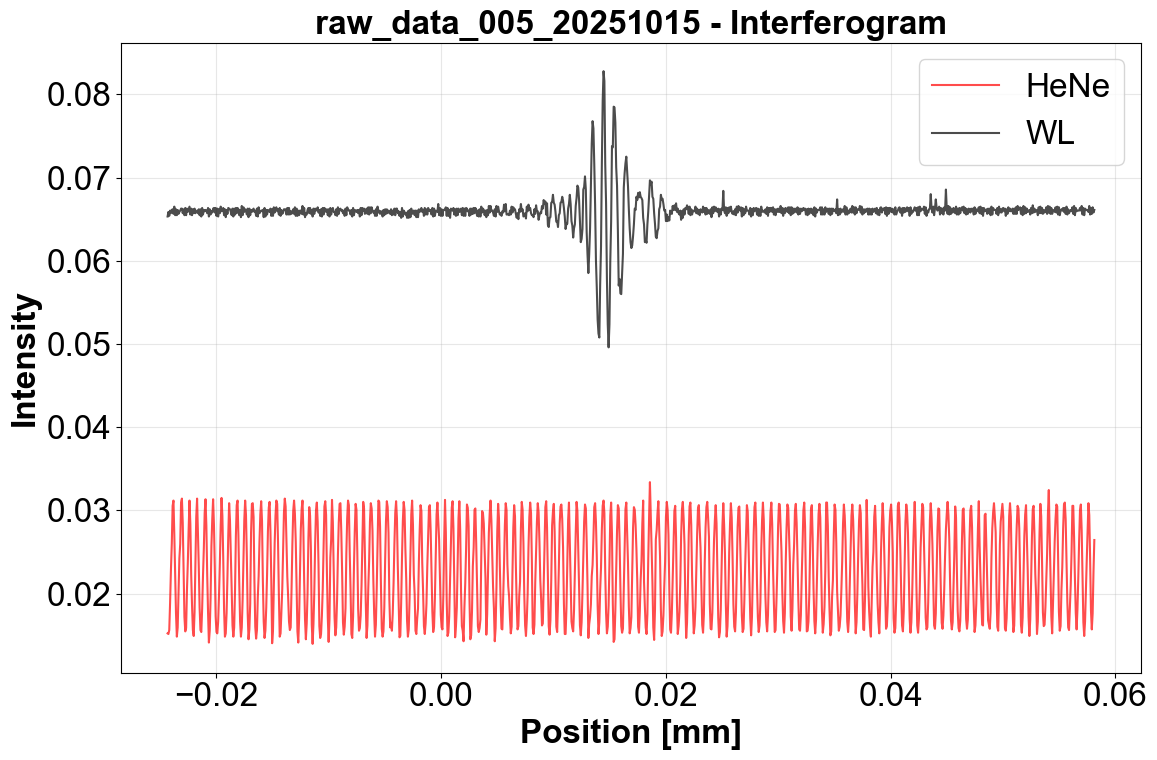

Zero delay correction: 0.022946
Polynomial coefficients: [ 11.92276562 -27.59535904  15.54909404]
Fit domain $\lambda$ = 0.874 to 1.490 $\mu m$


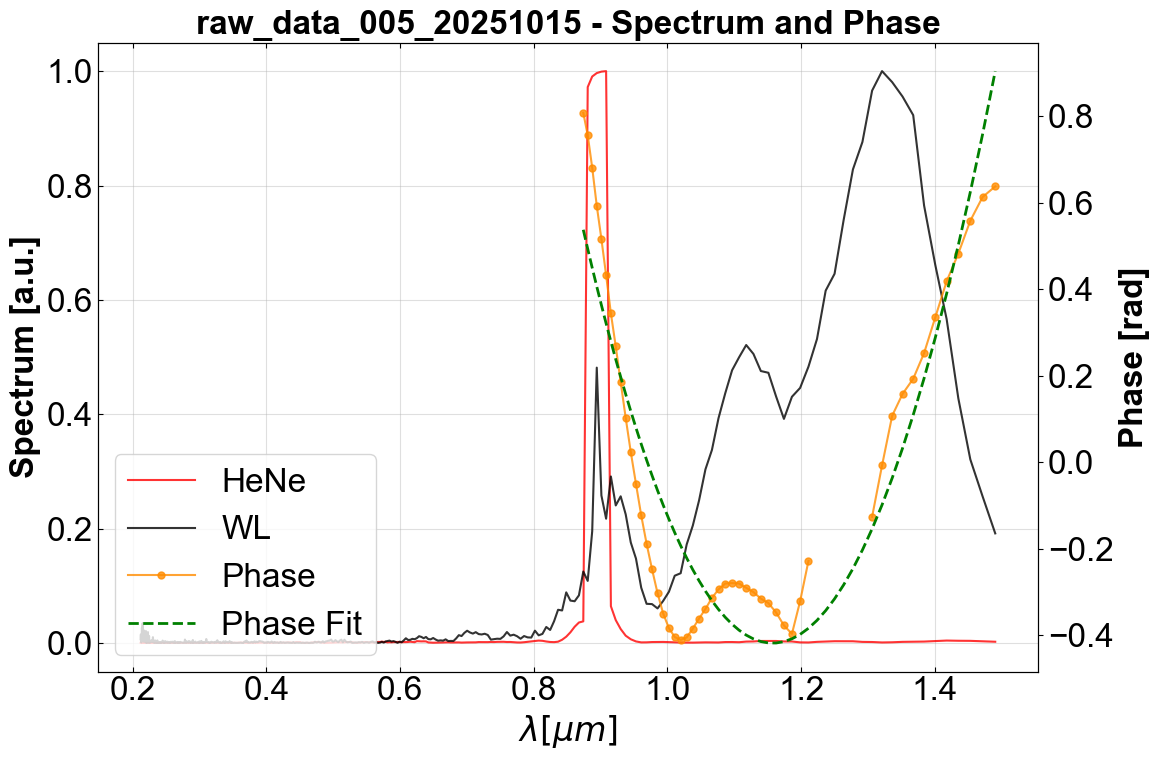


Processing: raw_data_006_20251015


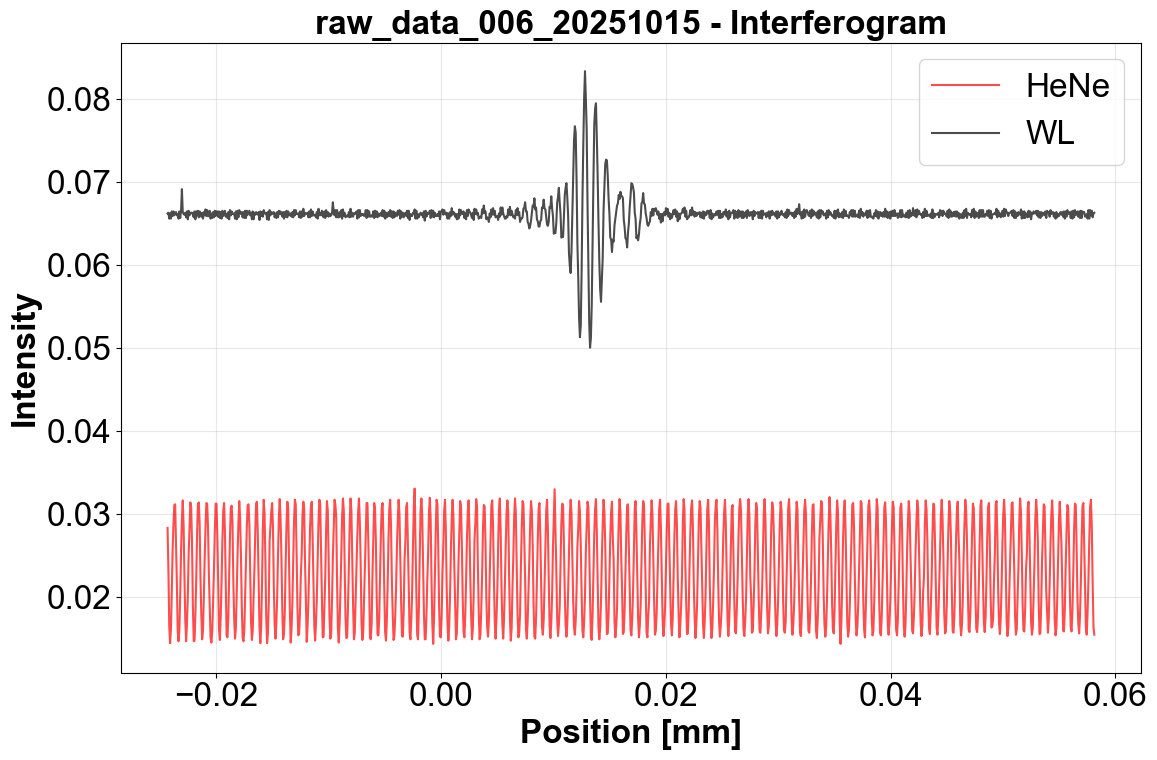

Zero delay correction: 0.025646
Polynomial coefficients: [ 14.84547561 -34.2218953   19.33594654]
Fit domain $\lambda$ = 0.901 to 1.453 $\mu m$


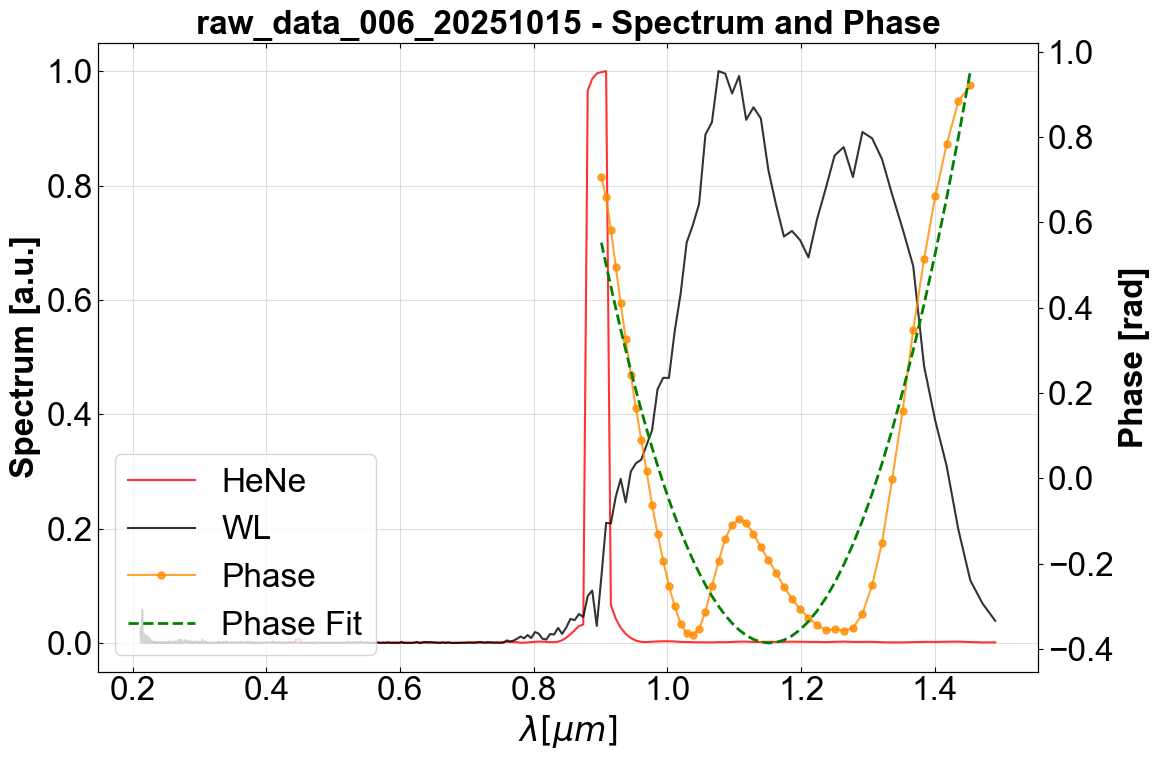


Processing: raw_data_007_20251015


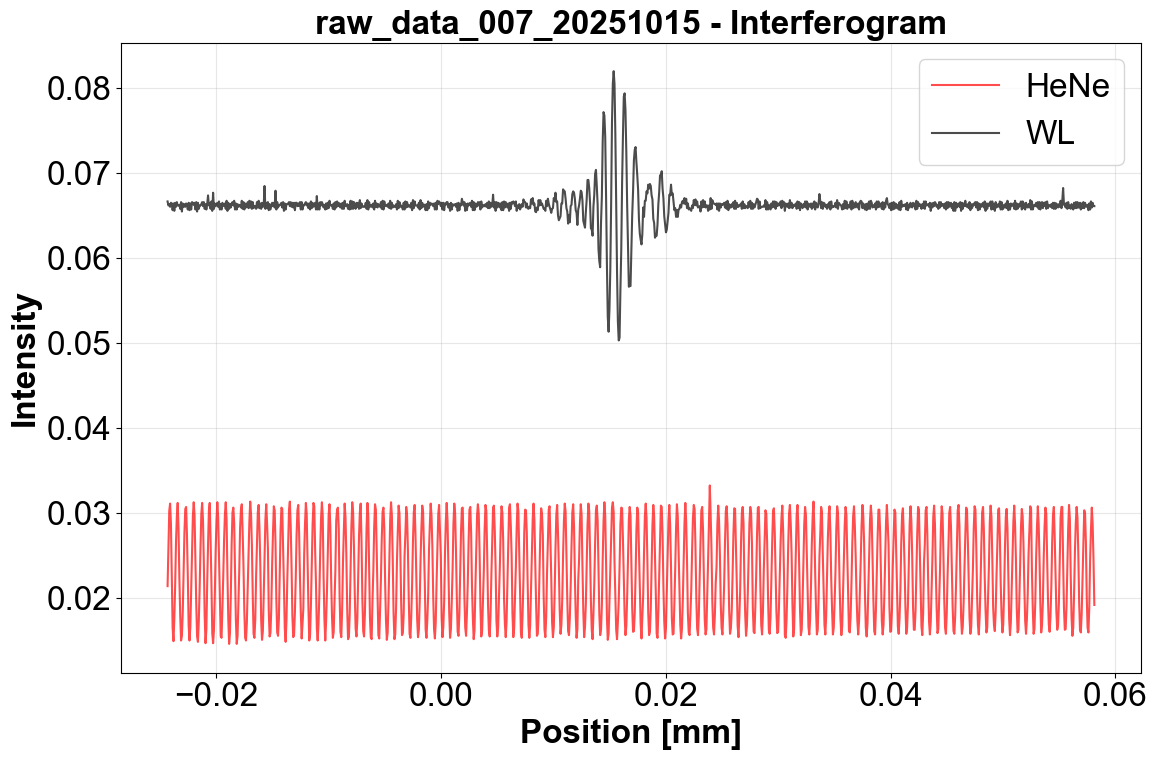

Zero delay correction: 0.025152
Polynomial coefficients: [ 16.17845778 -36.51182185  20.16694224]
Fit domain $\lambda$ = 0.874 to 1.435 $\mu m$


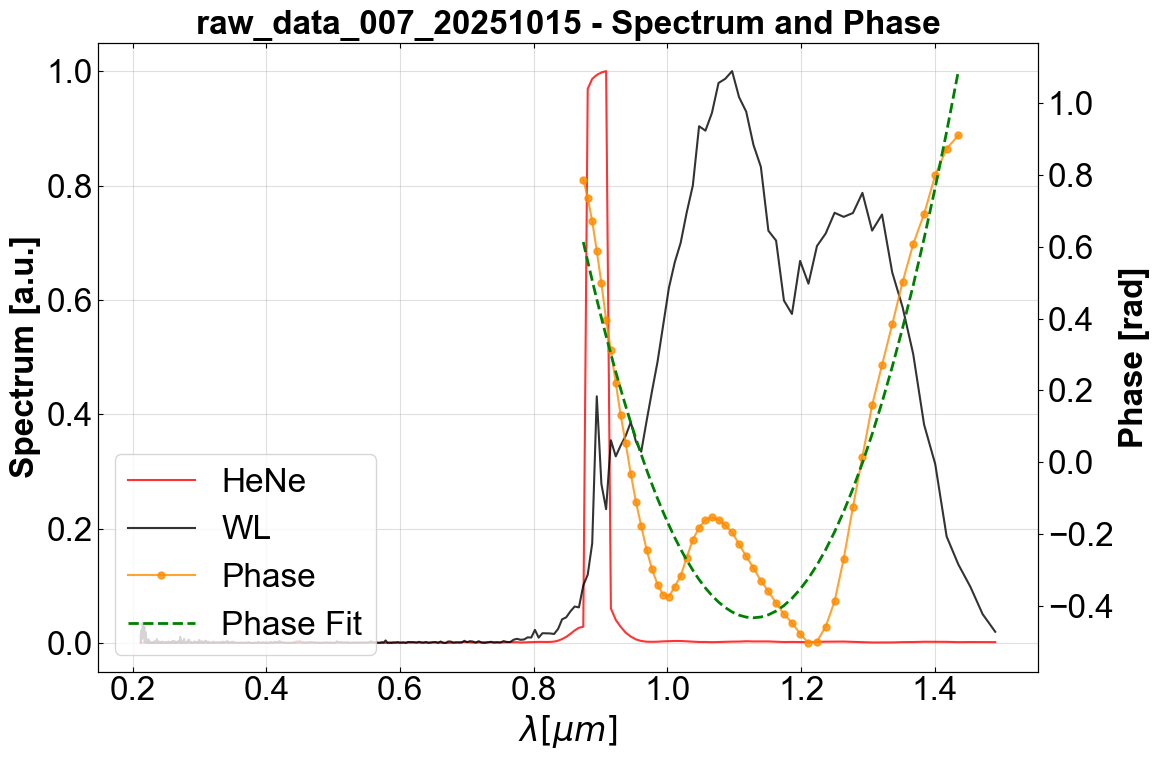


Processing: raw_data_008_20251015


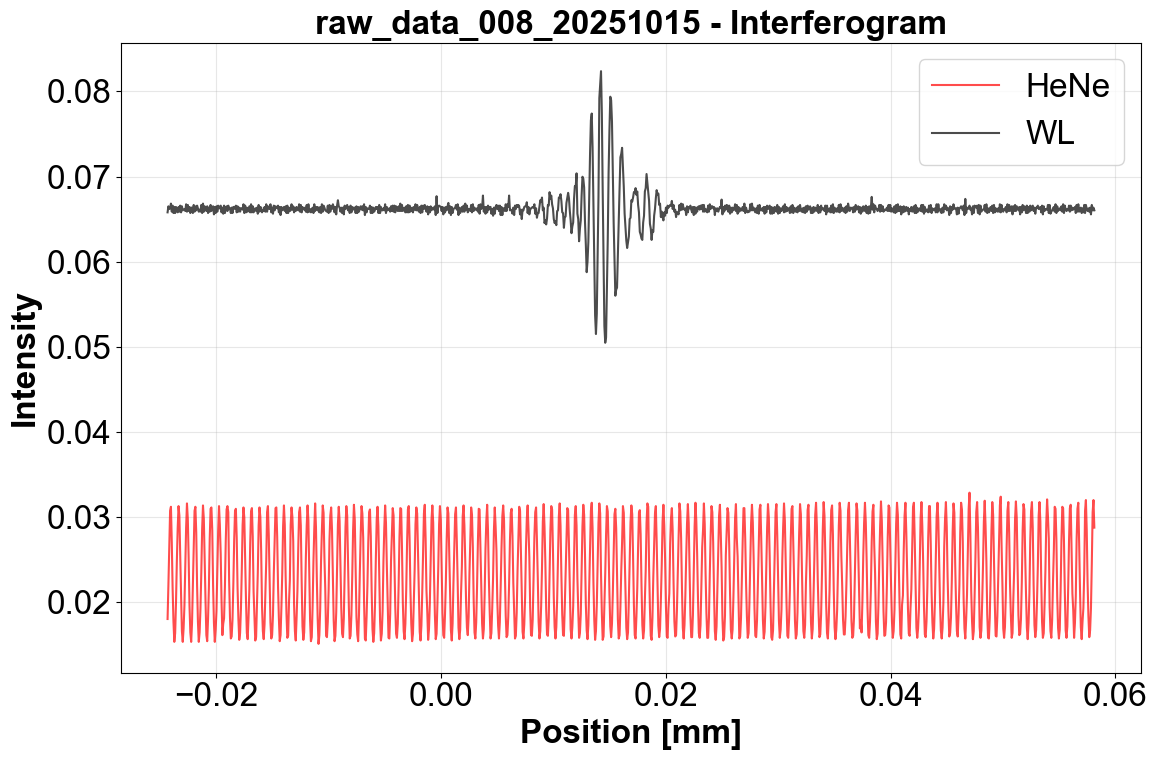

Zero delay correction: 0.021372
Polynomial coefficients: [ 17.93840221 -40.27119967  22.14543526]
Fit domain $\lambda$ = 0.874 to 1.435 $\mu m$


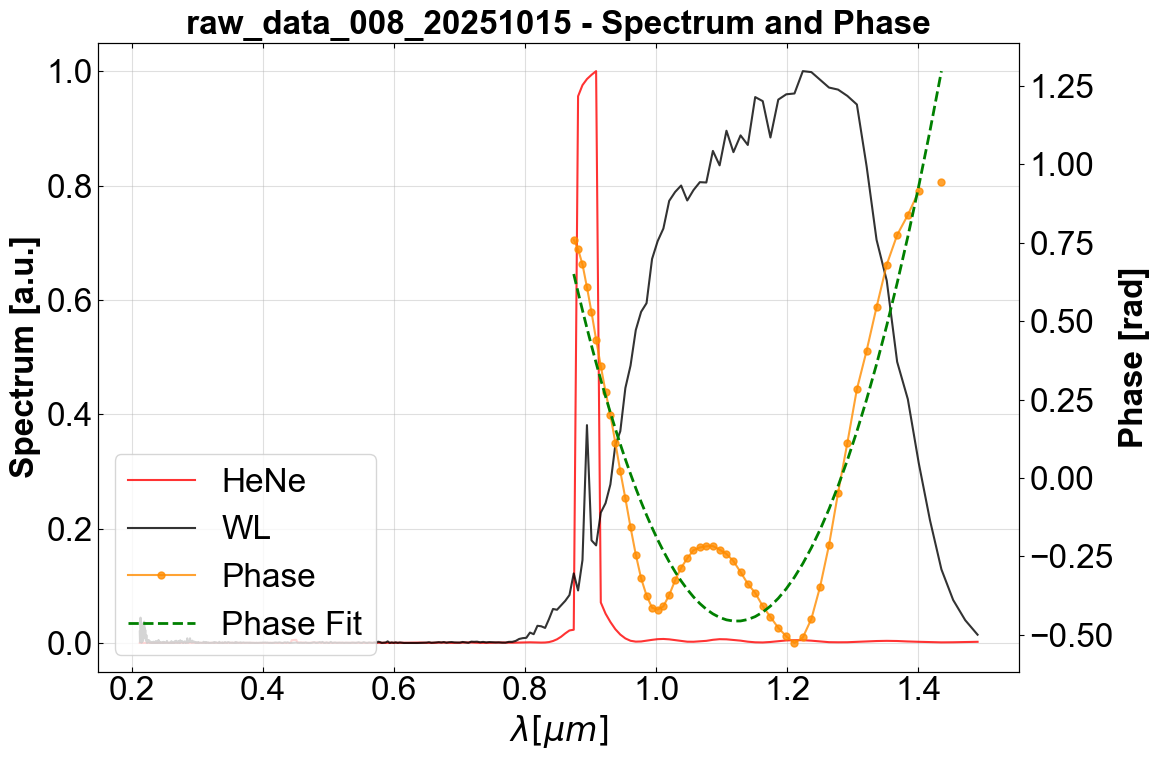


Processing: raw_data_009_20251015


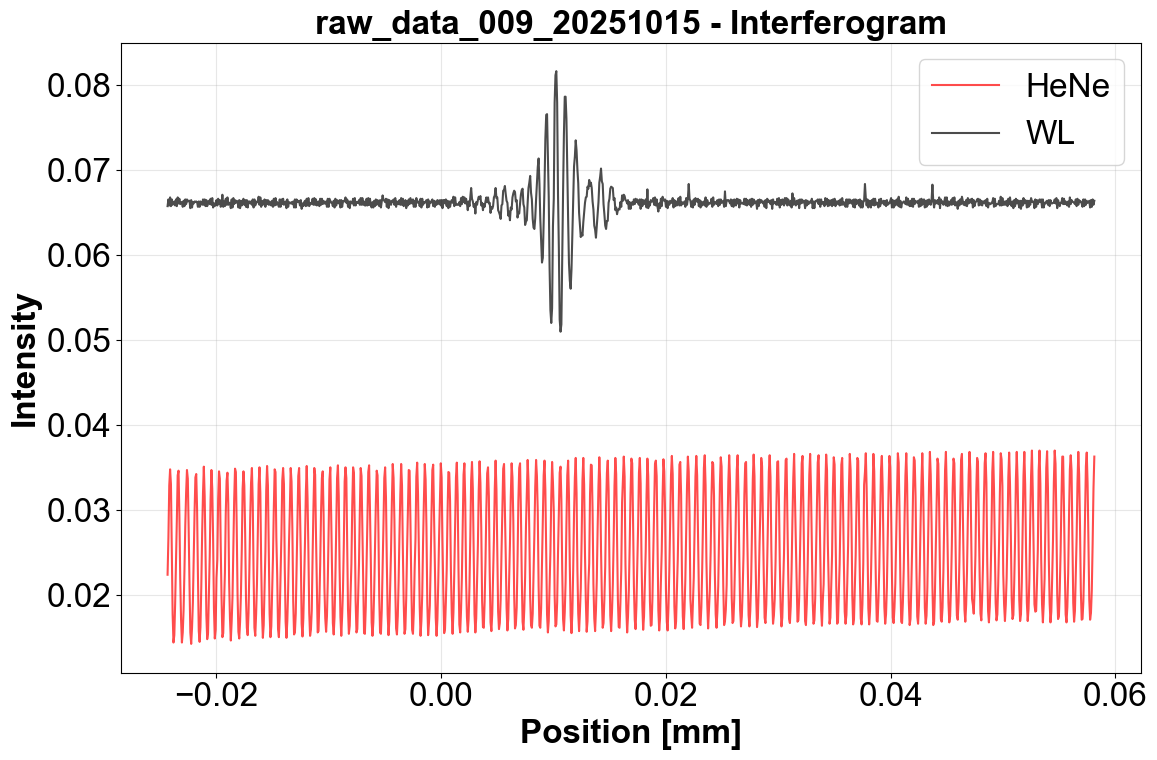

Zero delay correction: 0.026182
Polynomial coefficients: [ 17.45422176 -39.38361872  21.74901232]
Fit domain $\lambda$ = 0.874 to 1.435 $\mu m$


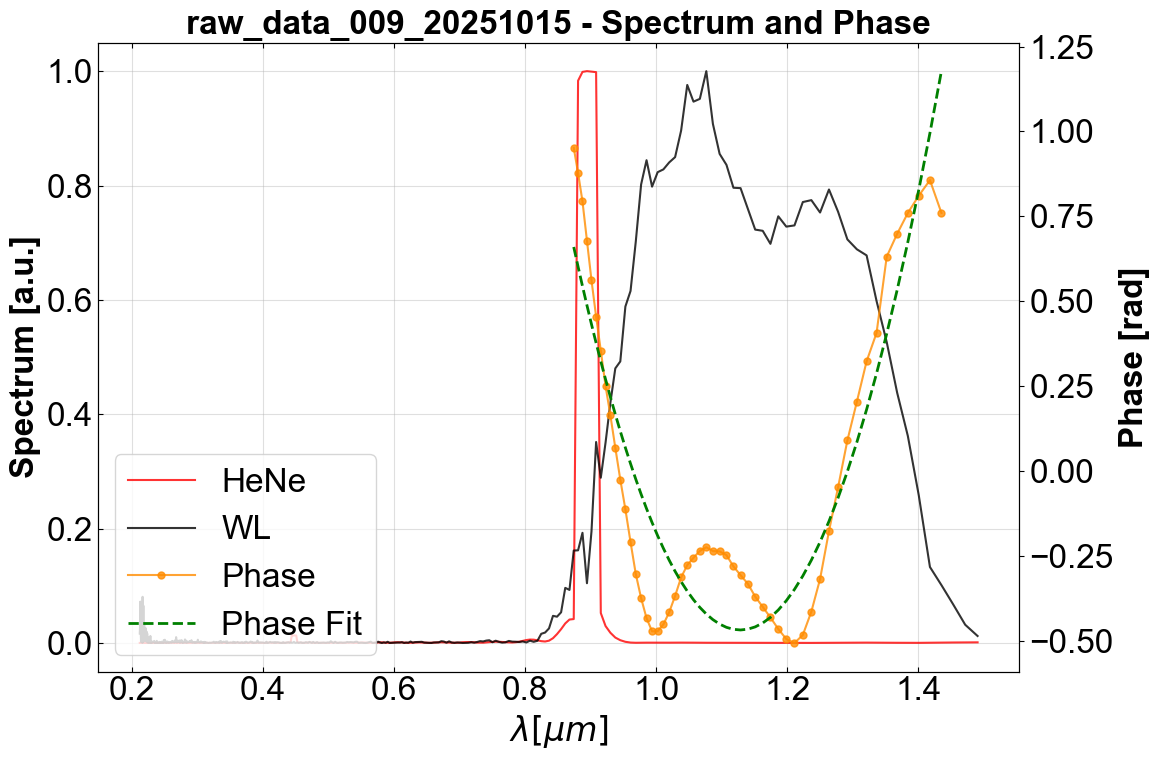


Processing: raw_data_010_20251015


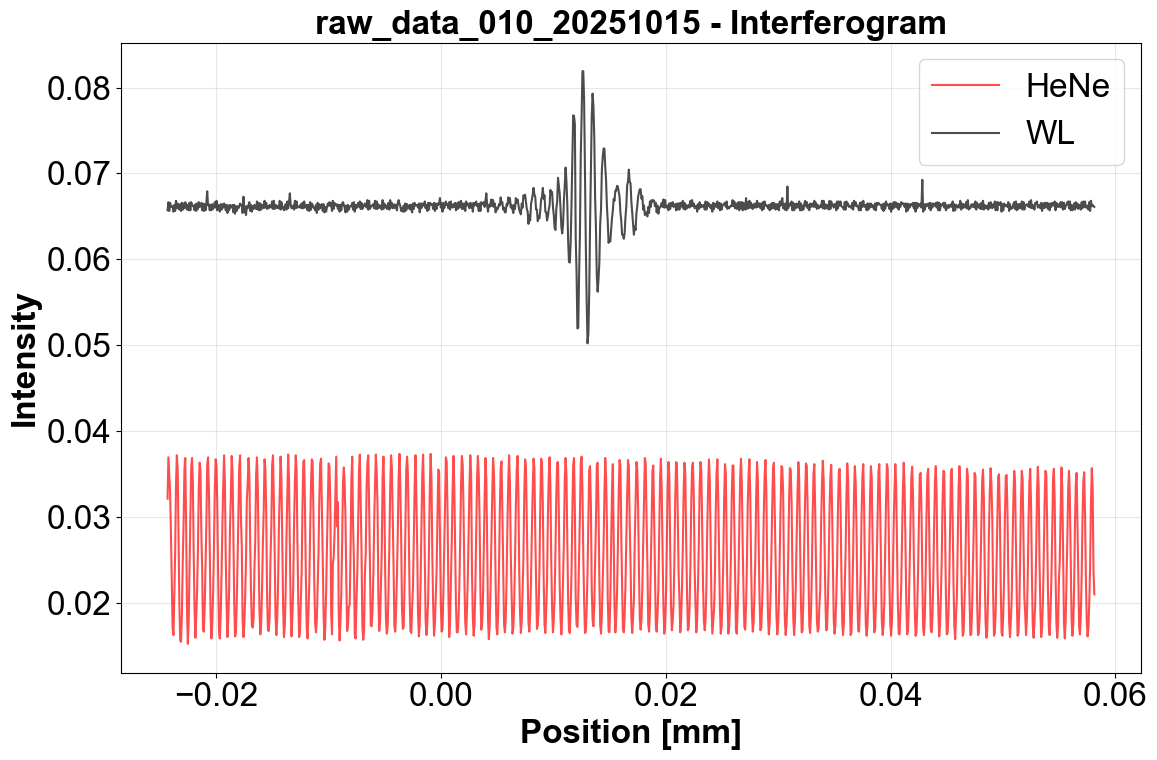

Zero delay correction: 0.025790
Polynomial coefficients: [ 13.40398555 -30.43284377  16.85156843]
Fit domain $\lambda$ = 0.861 to 1.472 $\mu m$


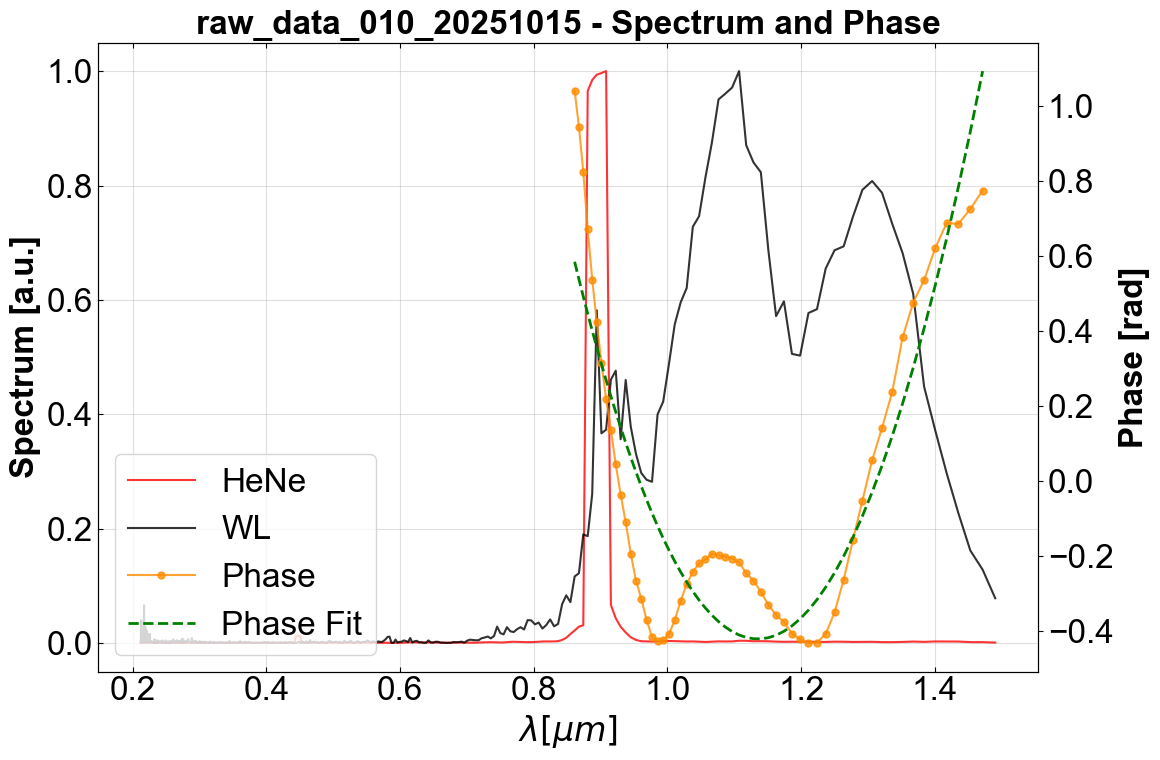


Processing: raw_data_011_20251015


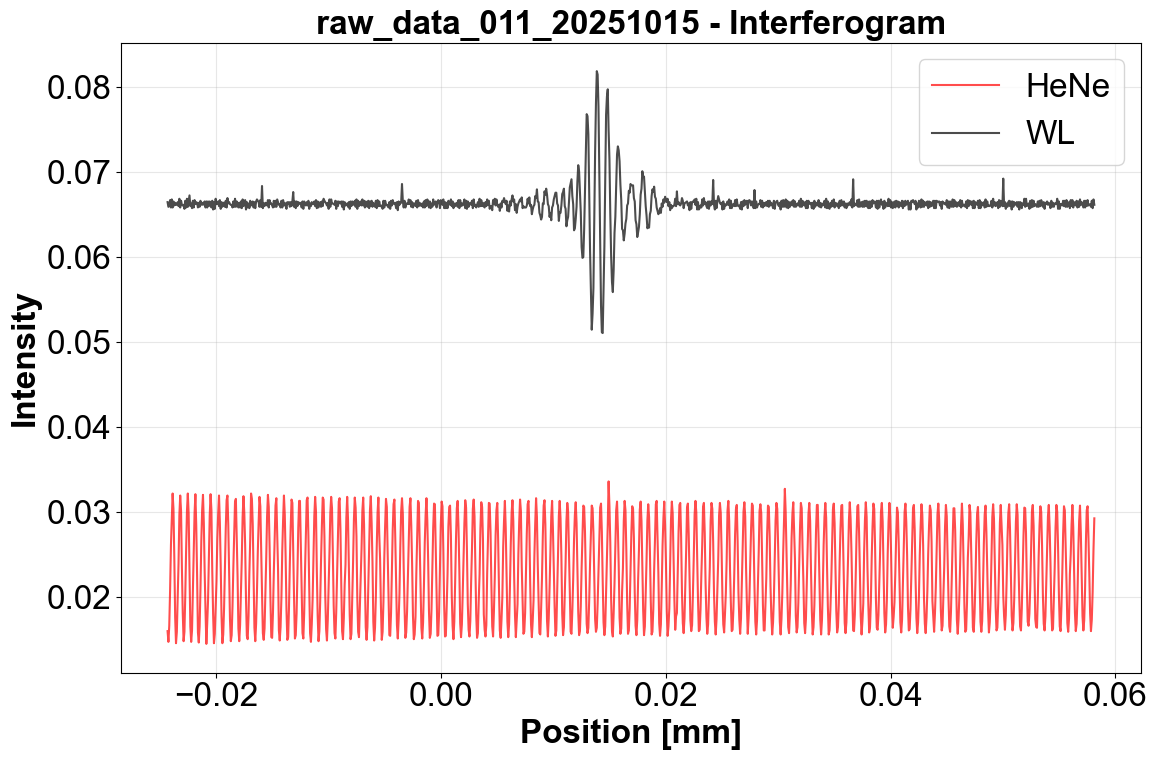

Zero delay correction: 0.022082
Polynomial coefficients: [ 16.21333241 -36.46885534  20.08834783]
Fit domain $\lambda$ = 0.874 to 1.435 $\mu m$


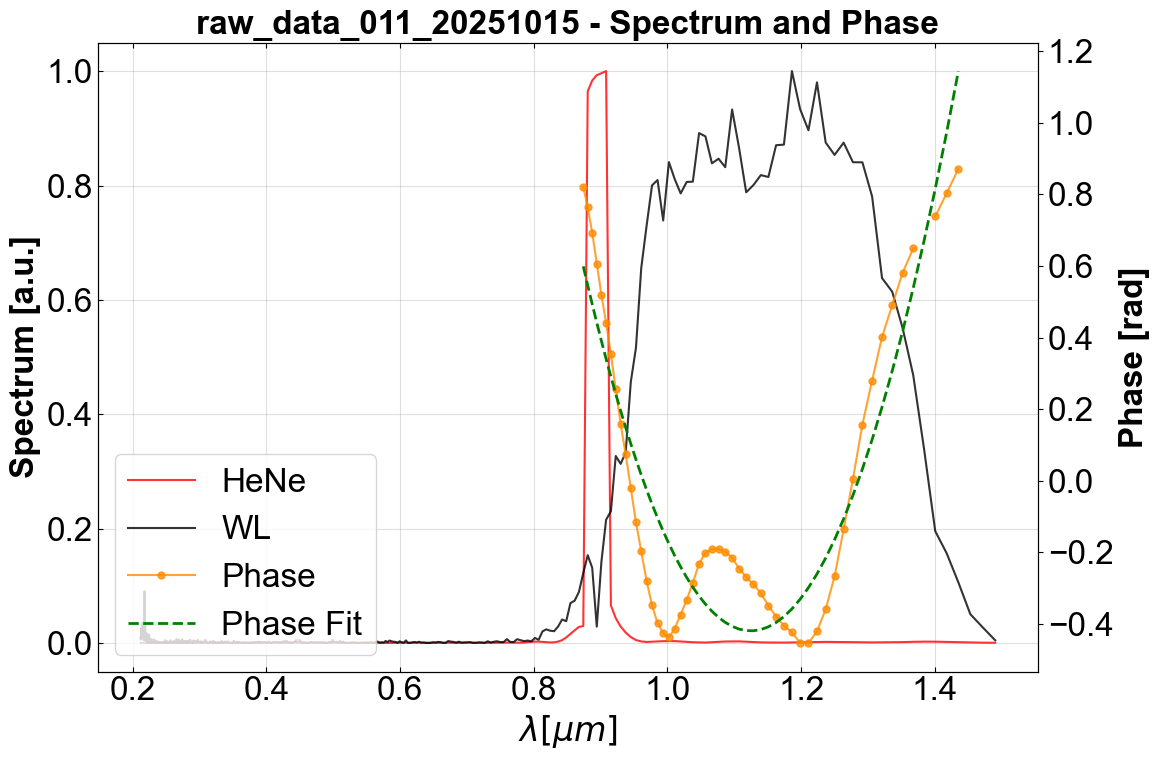


Processing: raw_data_012_20251015


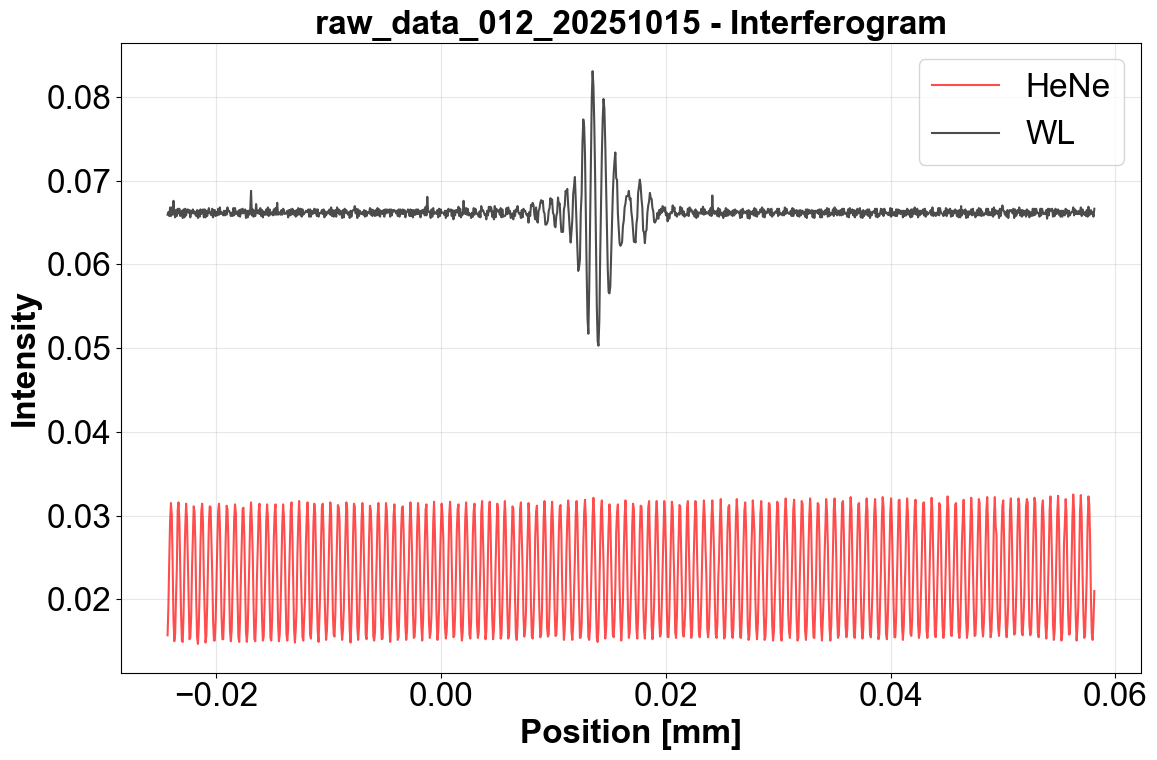

Zero delay correction: 0.025224
Polynomial coefficients: [ 16.56759152 -37.73669977  20.97746836]
Fit domain $\lambda$ = 0.868 to 1.472 $\mu m$


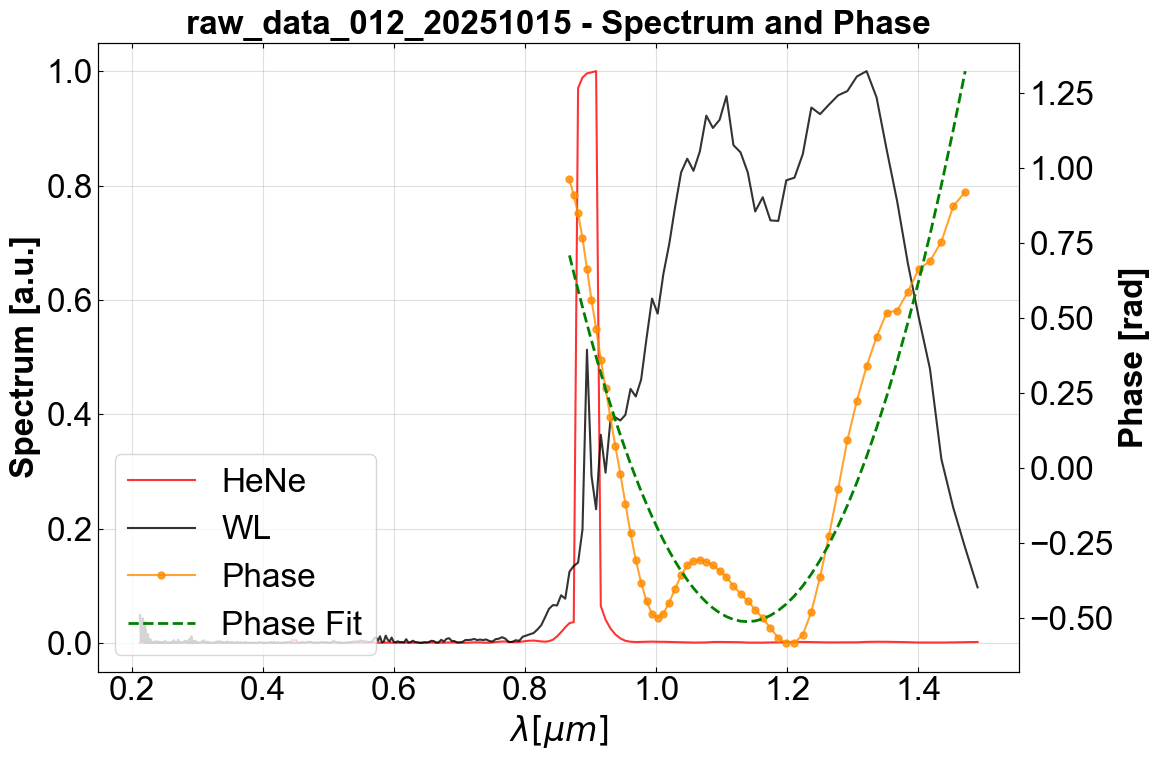


Processing: raw_data_013_20251015


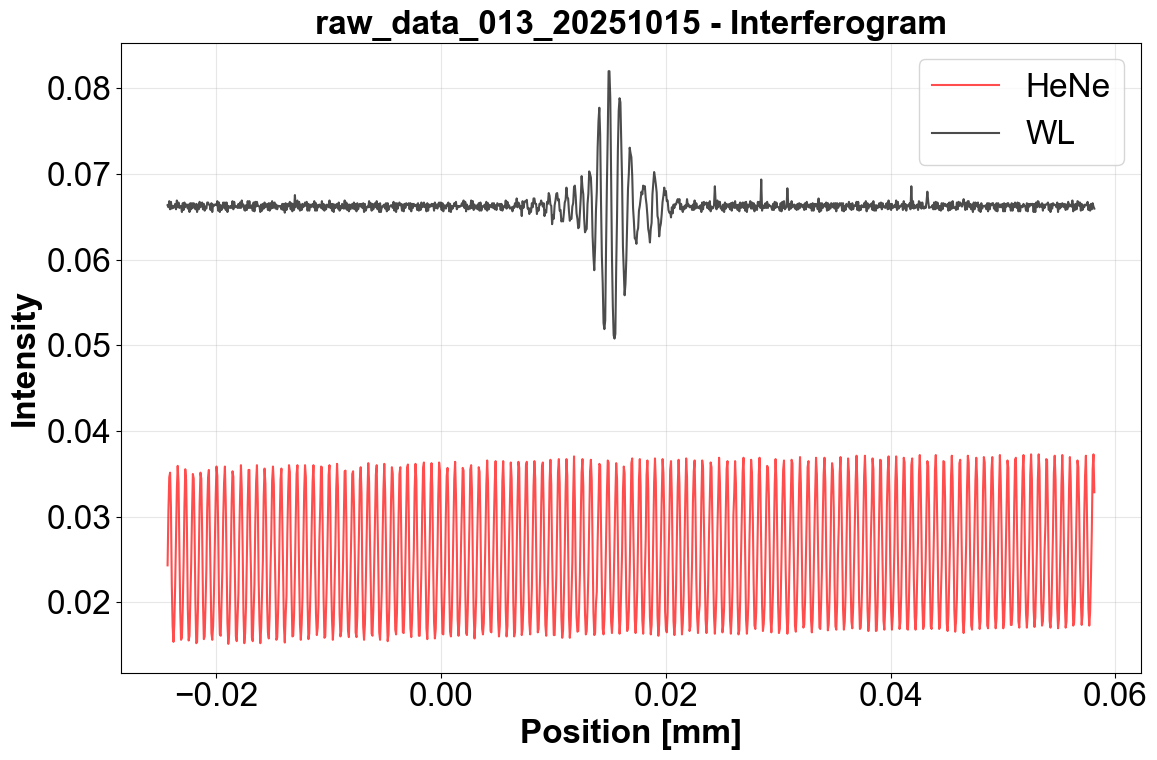

Zero delay correction: 0.020724
Polynomial coefficients: [ 15.97238482 -36.67637846  20.62952388]
Fit domain $\lambda$ = 0.894 to 1.453 $\mu m$


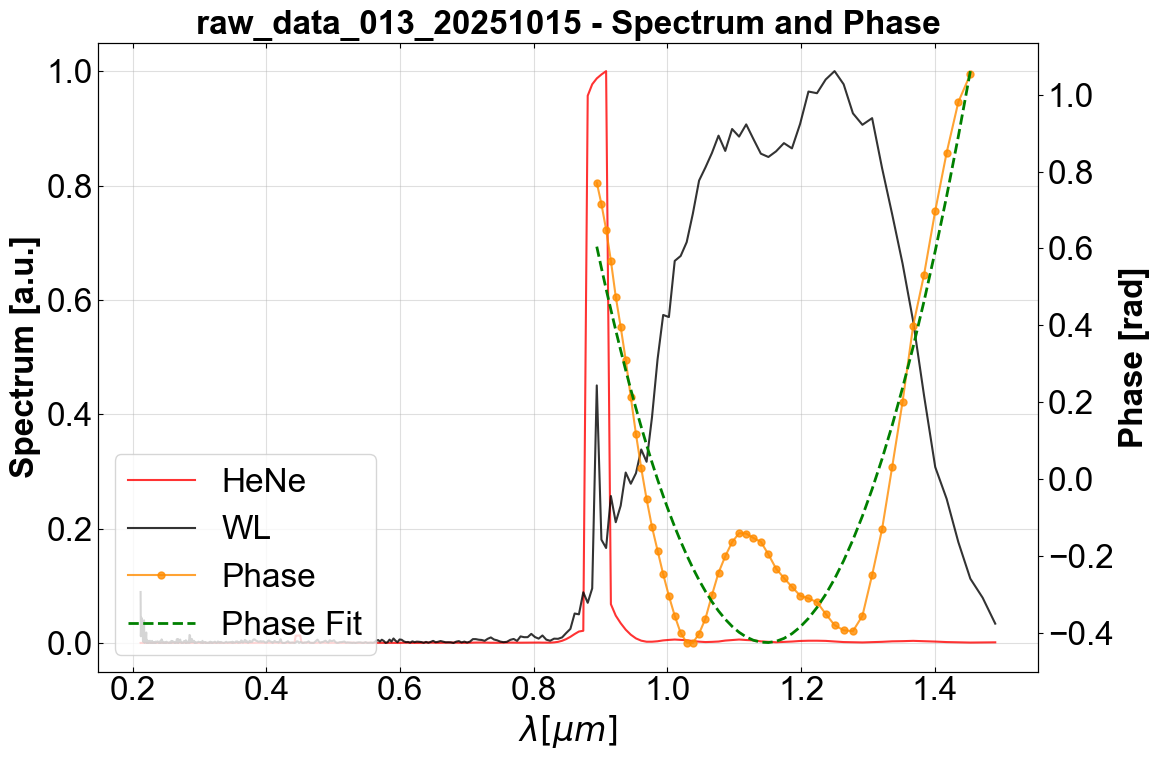


Processing: raw_data_014_20251015


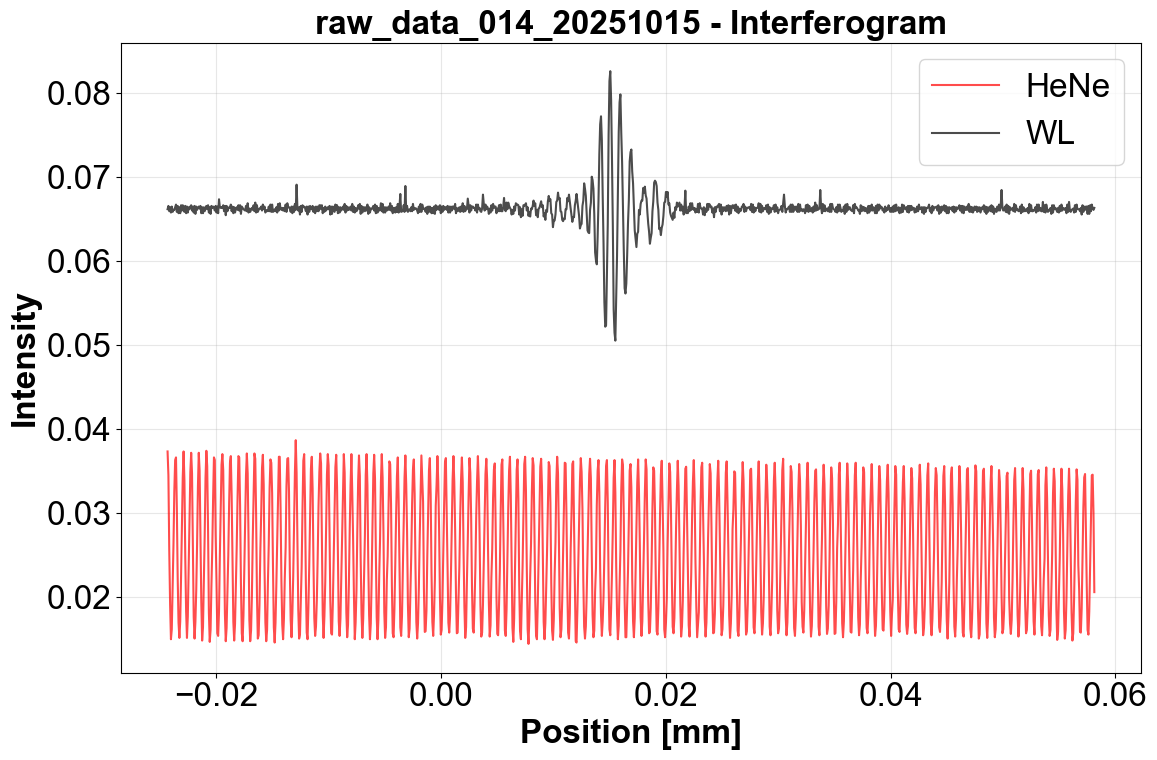

Zero delay correction: 0.023400
Polynomial coefficients: [ 15.10060071 -33.35607309  17.96516062]
Fit domain $\lambda$ = 0.836 to 1.435 $\mu m$


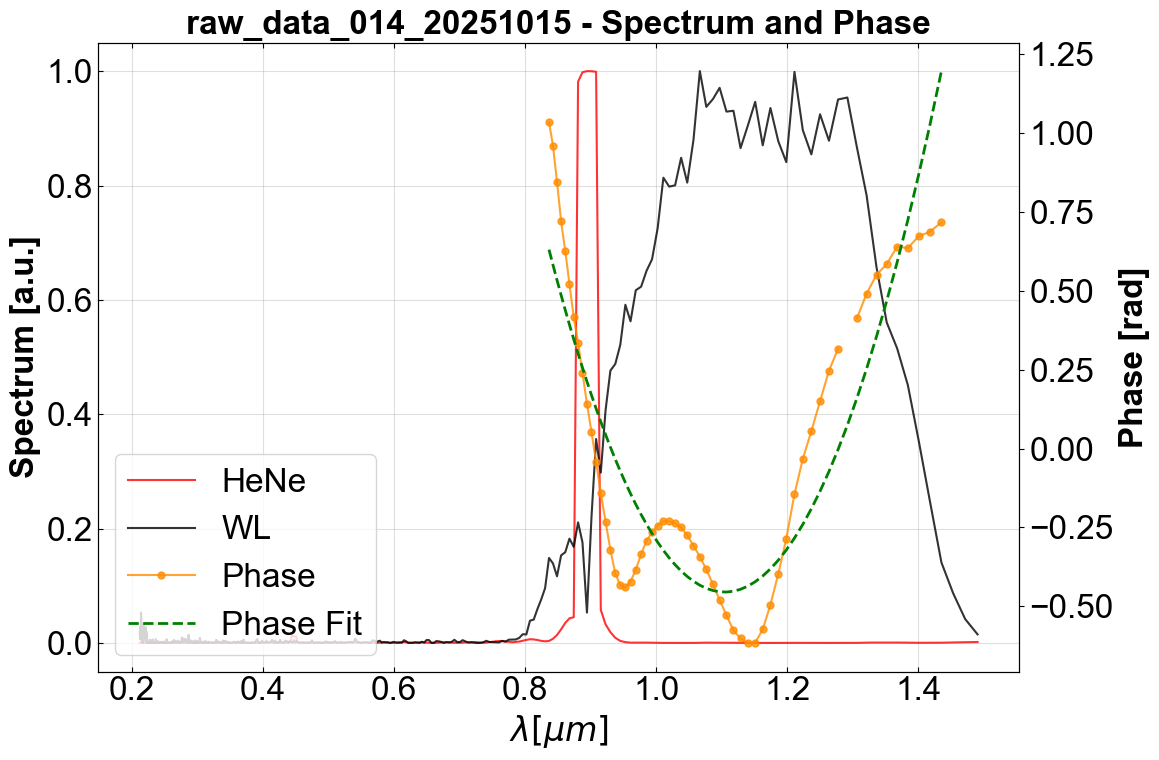


Processing: raw_data_015_20251015
  Skipping raw_data_015_20251015 (in exclusion list)

Processing: raw_data_016_20251015


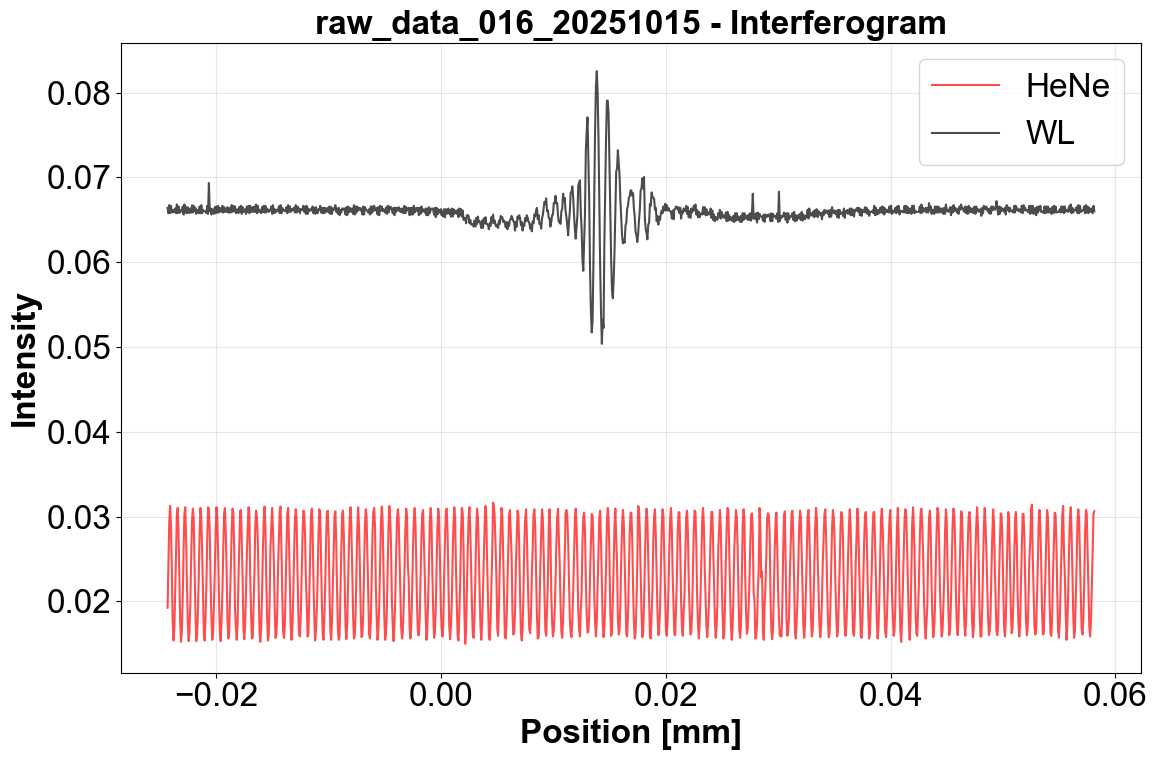

Zero delay correction: 0.021232
Polynomial coefficients: [ 15.89526025 -35.71821469  19.58751511]
Fit domain $\lambda$ = 0.855 to 1.472 $\mu m$


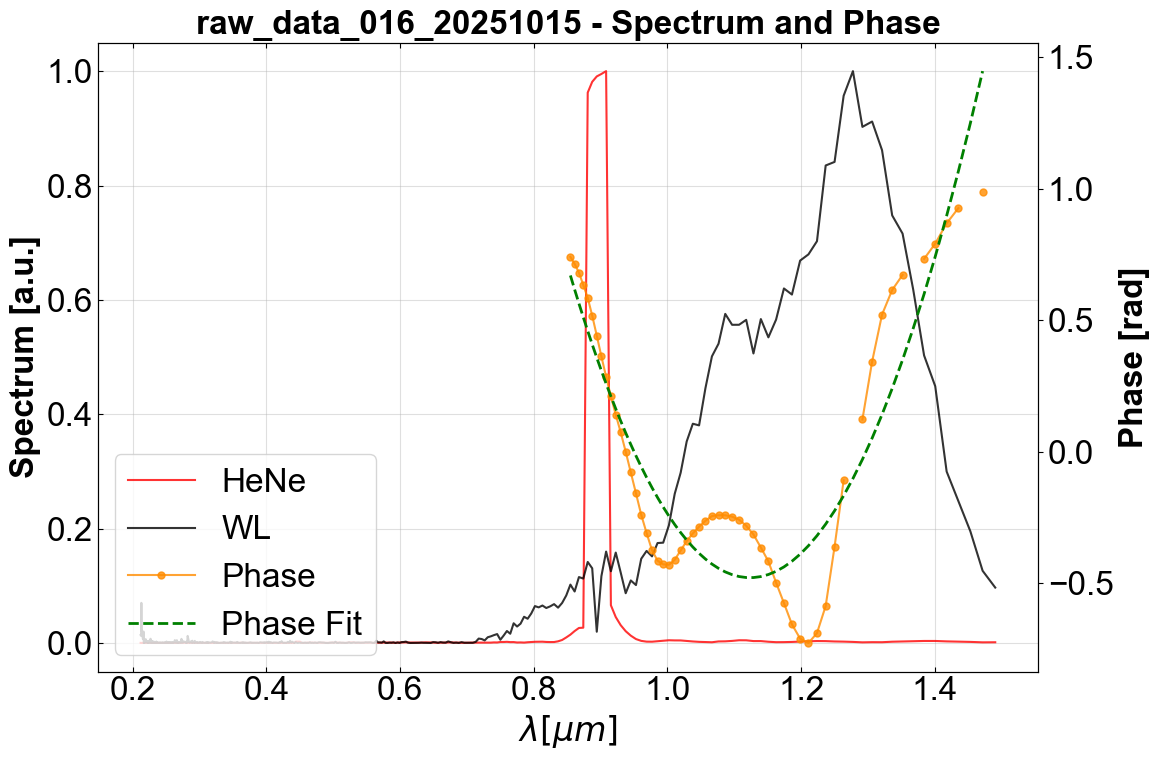


Processing: raw_data_017_20251015


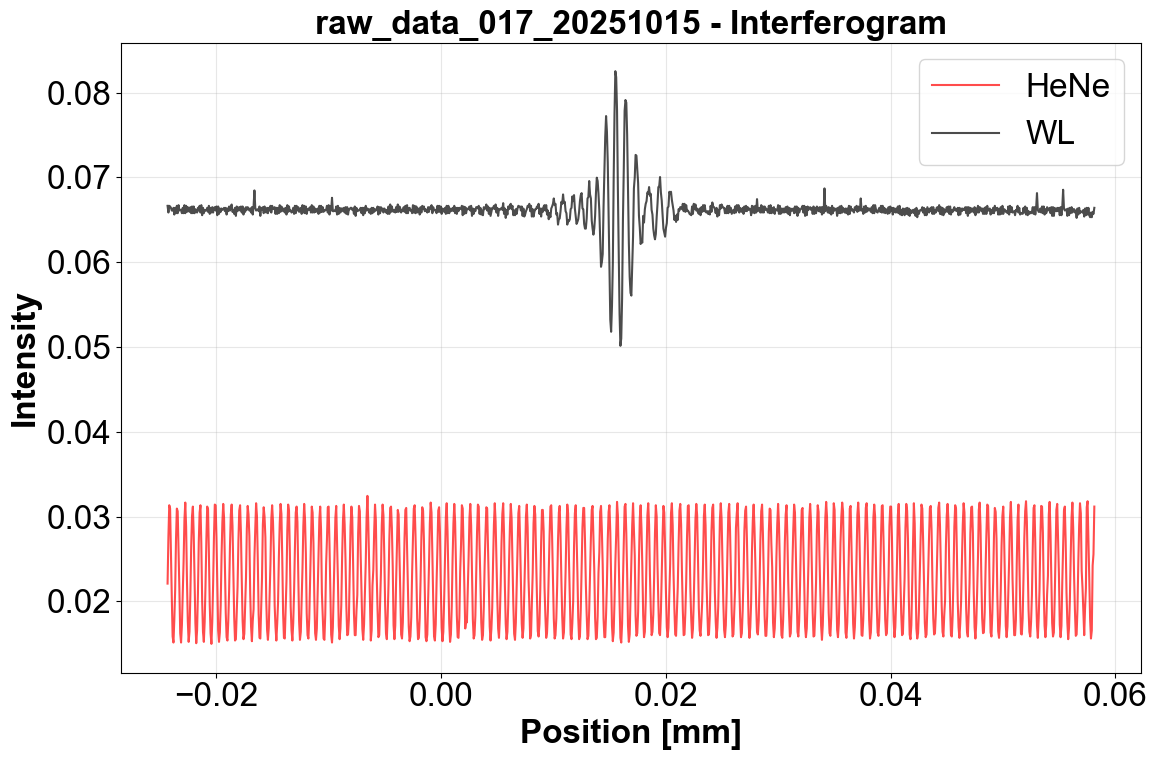

Zero delay correction: 0.025027
Polynomial coefficients: [ 16.61705056 -37.1604732   20.39217584]
Fit domain $\lambda$ = 0.881 to 1.401 $\mu m$


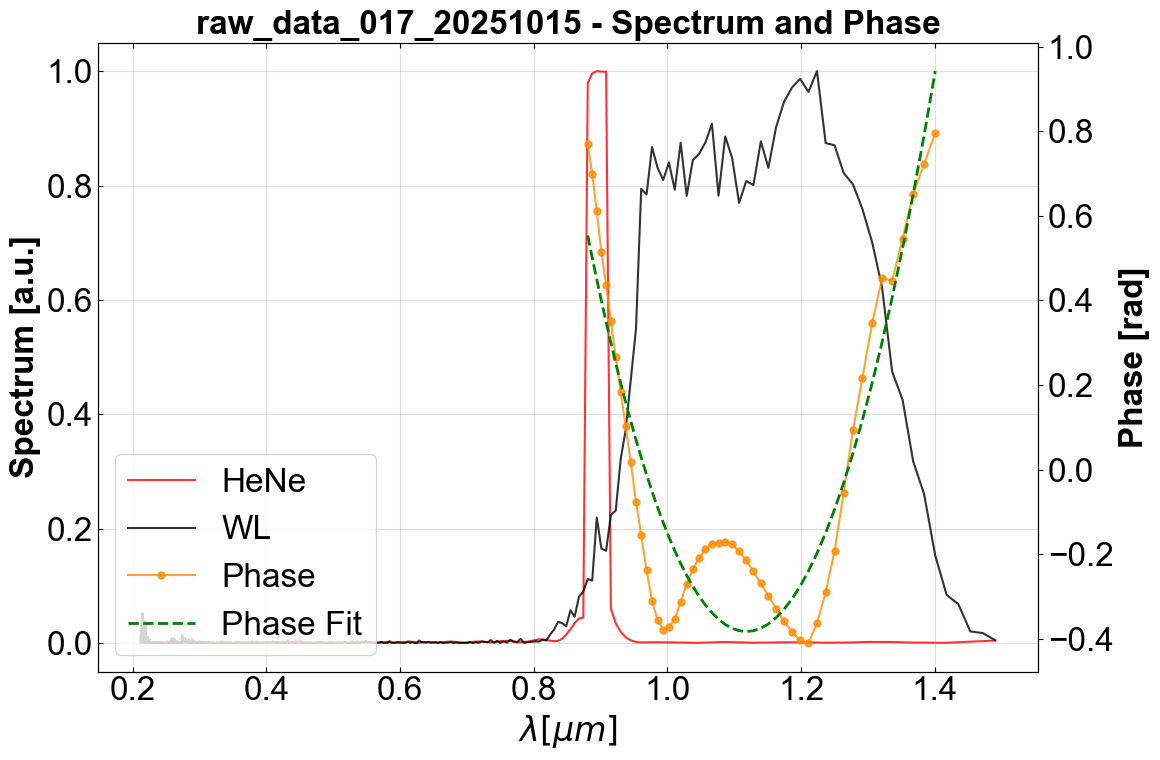


Processing: raw_data_018_20251015


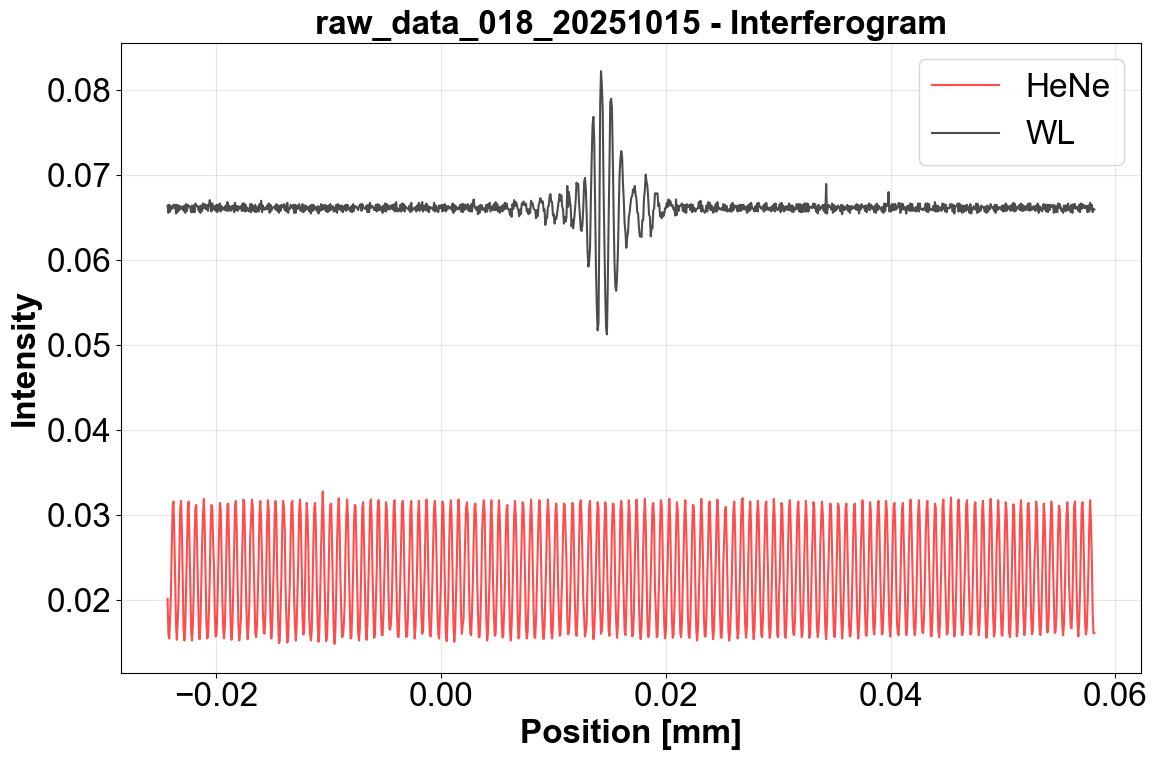

Zero delay correction: 0.020659
Polynomial coefficients: [ 15.22795438 -32.89975063  17.37469984]
Fit domain $\lambda$ = 0.830 to 1.384 $\mu m$


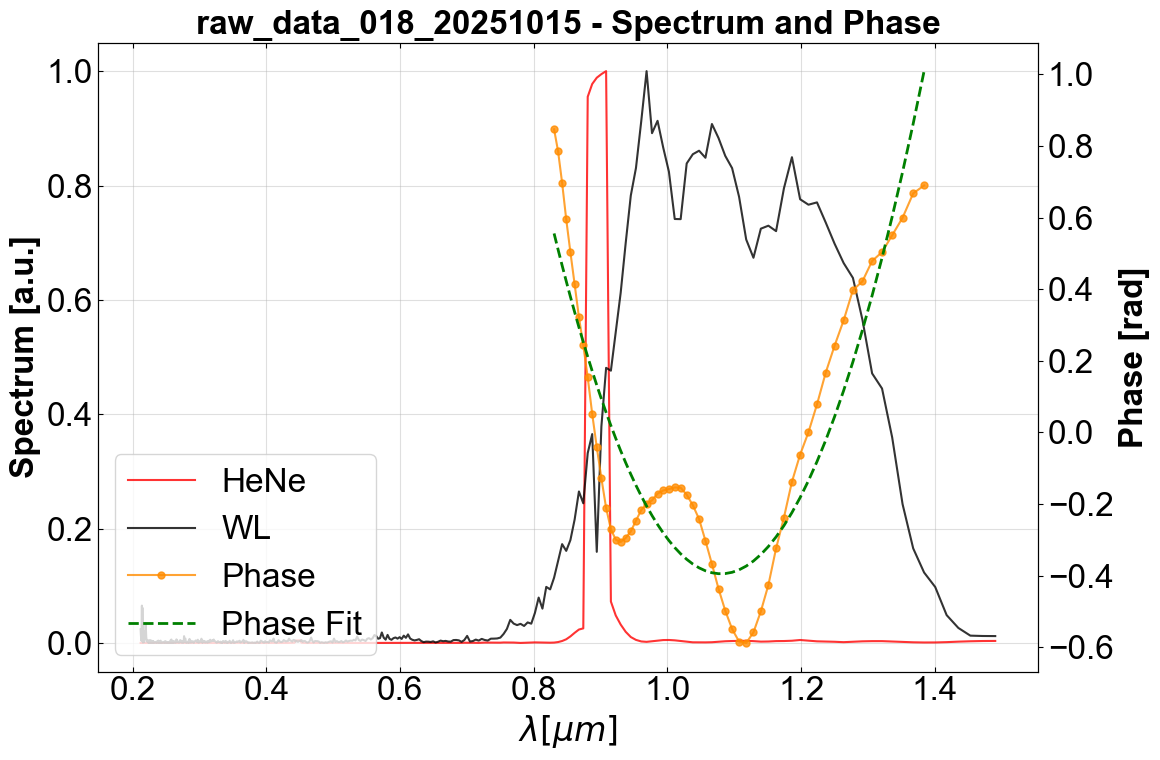


Processing: raw_data_019_20251015


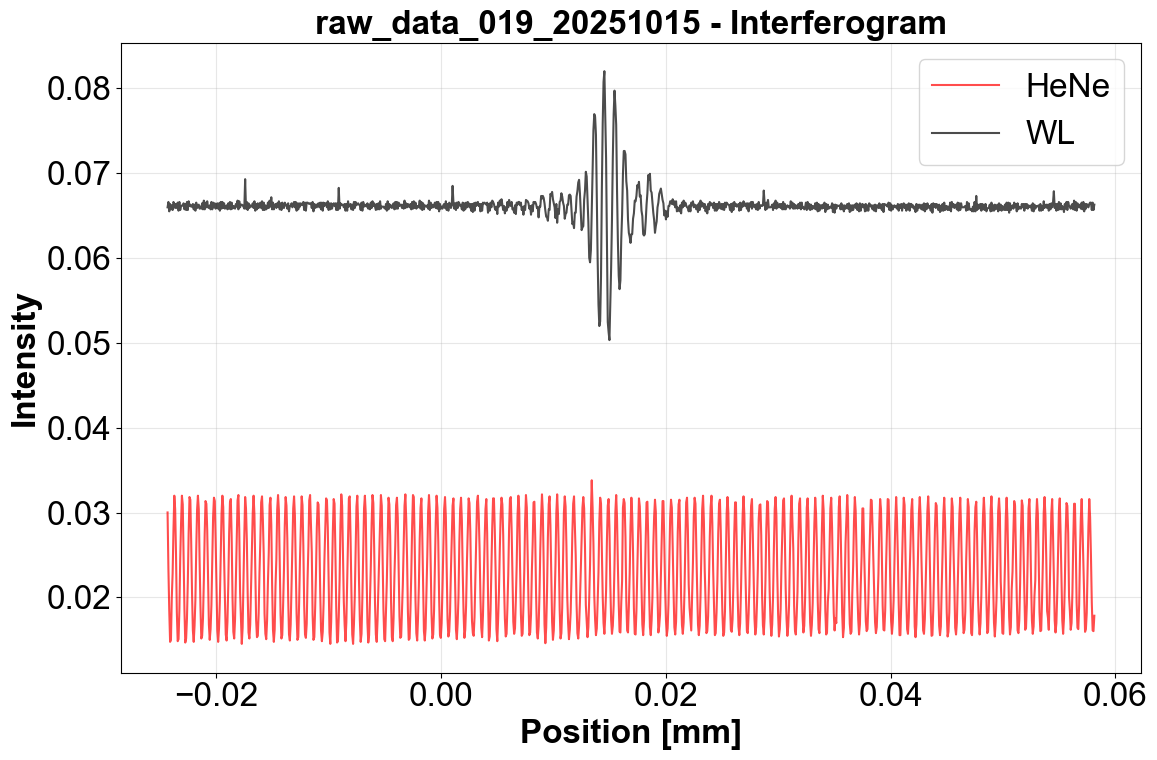

Zero delay correction: 0.025477
Polynomial coefficients: [ 16.02930557 -35.64300502  19.35171304]
Fit domain $\lambda$ = 0.849 to 1.435 $\mu m$


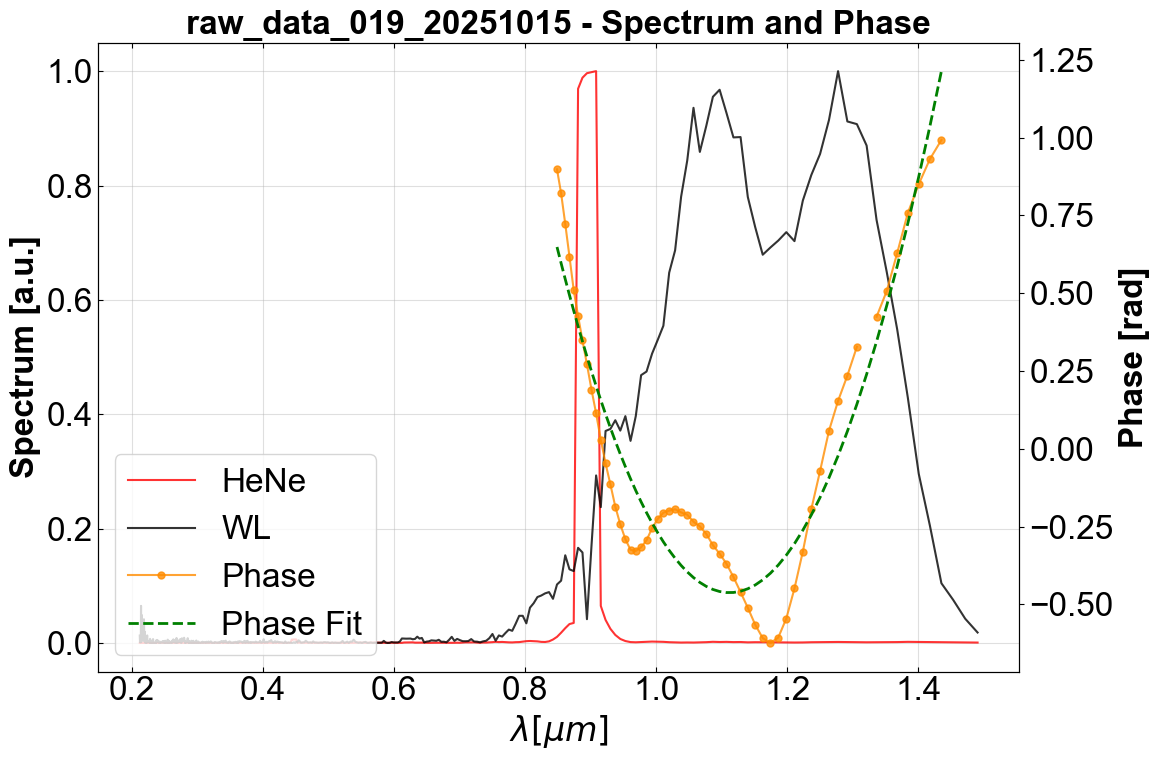


Processing: raw_data_020_20251015


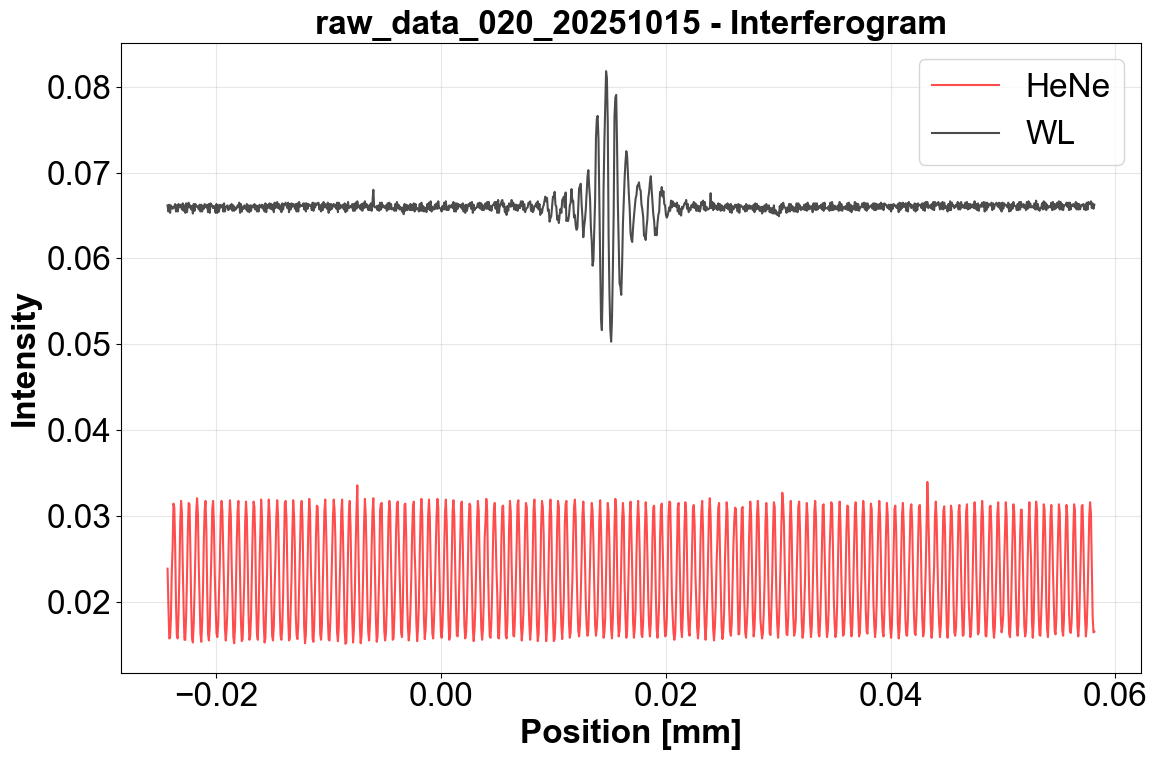

Zero delay correction: 0.025450
Polynomial coefficients: [ 15.8754824  -36.16897322  20.11067081]
Fit domain $\lambda$ = 0.868 to 1.472 $\mu m$


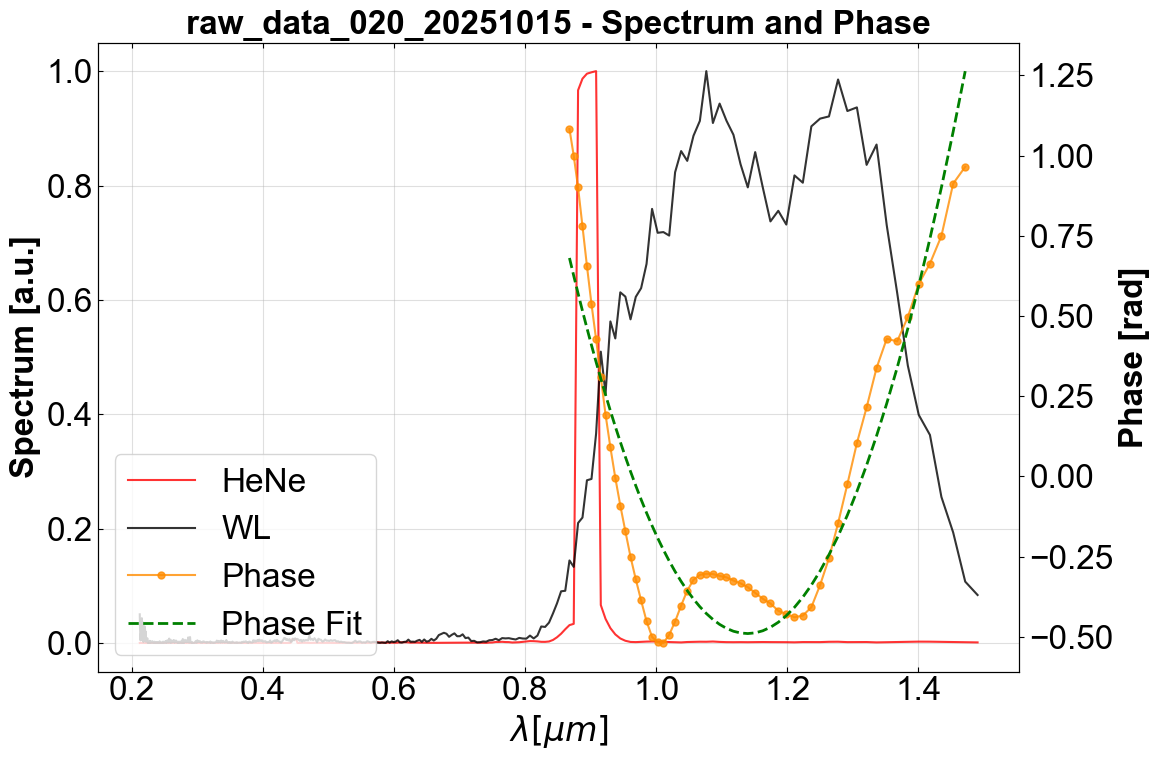


Processing: raw_data_021_20251015
  Skipping raw_data_021_20251015 (in exclusion list)

Processing: raw_data_022_20251015


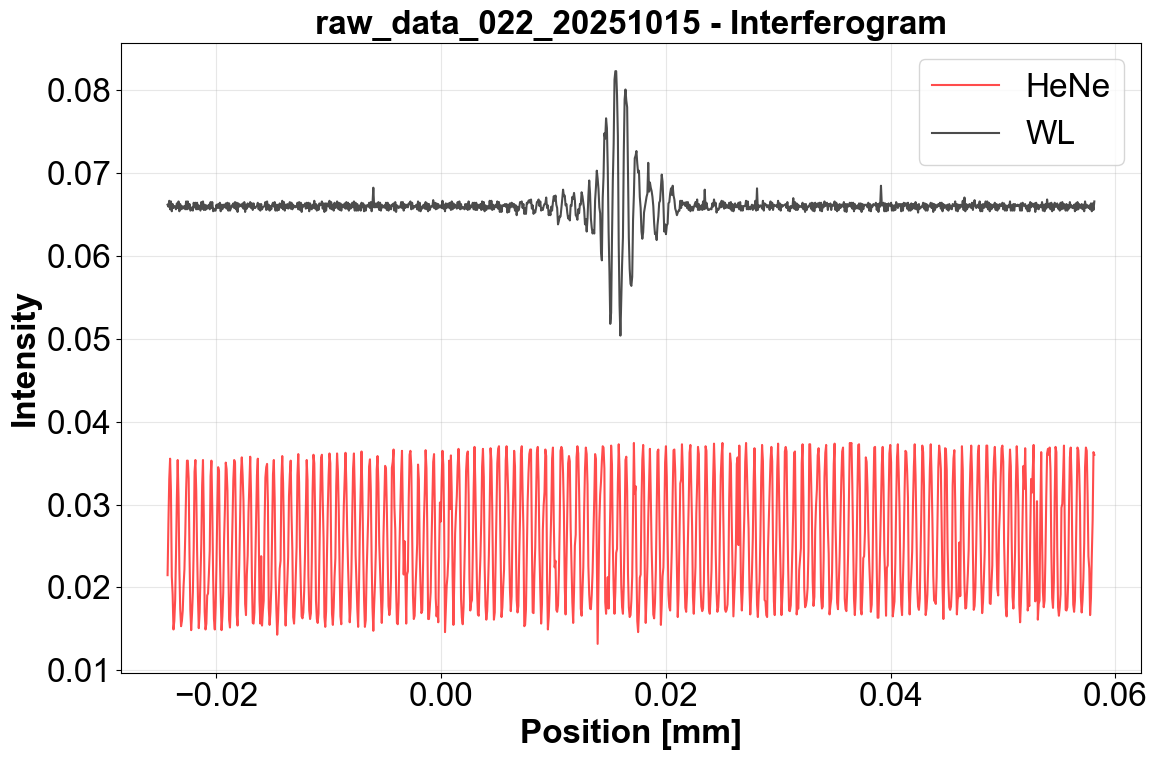

Zero delay correction: 0.024776
Polynomial coefficients: [ 14.89359842 -34.79927727  19.886964  ]
Fit domain $\lambda$ = 0.901 to 1.490 $\mu m$


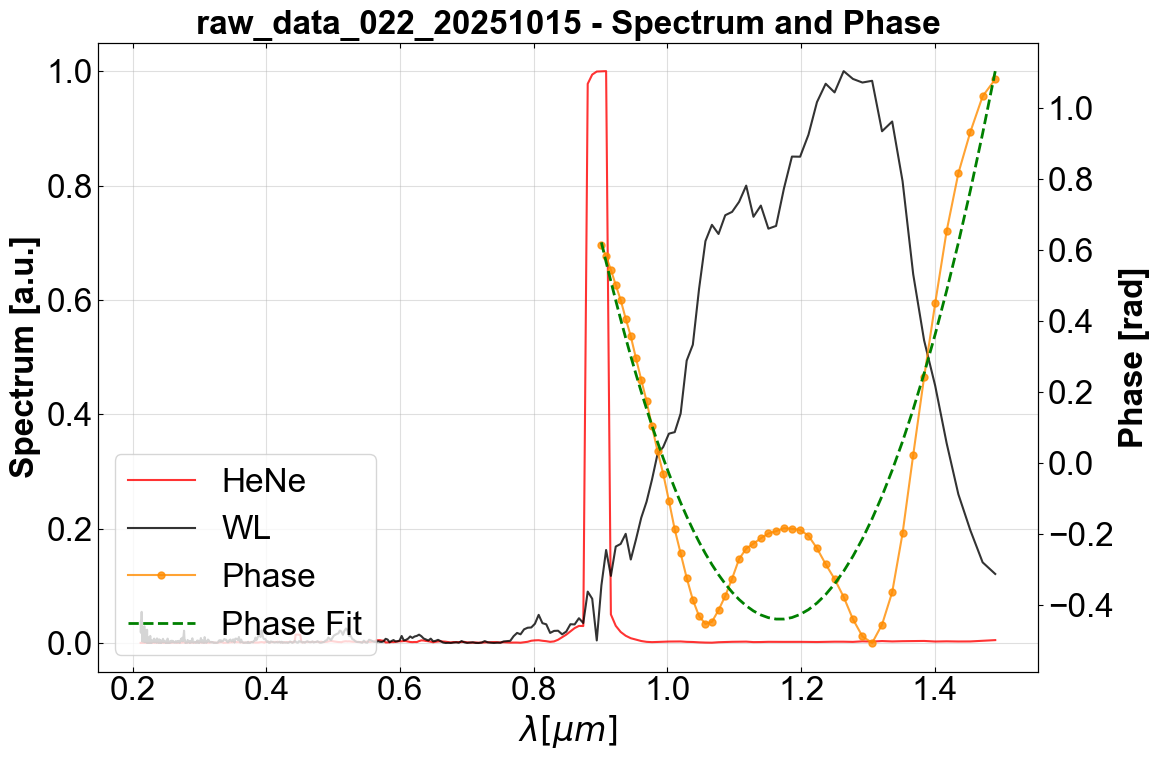


Processing: raw_data_023_20251015


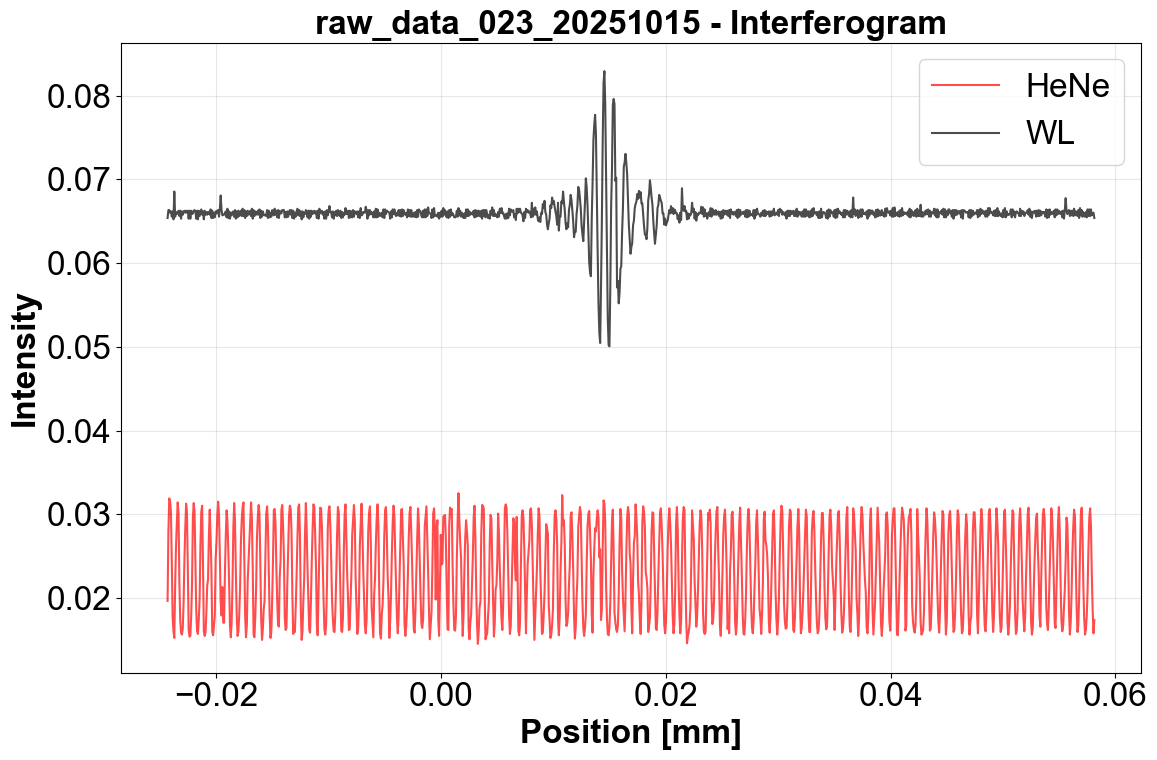

Zero delay correction: 0.024963
Polynomial coefficients: [ 11.60636313 -25.8173869   14.01900719]
Fit domain $\lambda$ = 0.849 to 1.435 $\mu m$


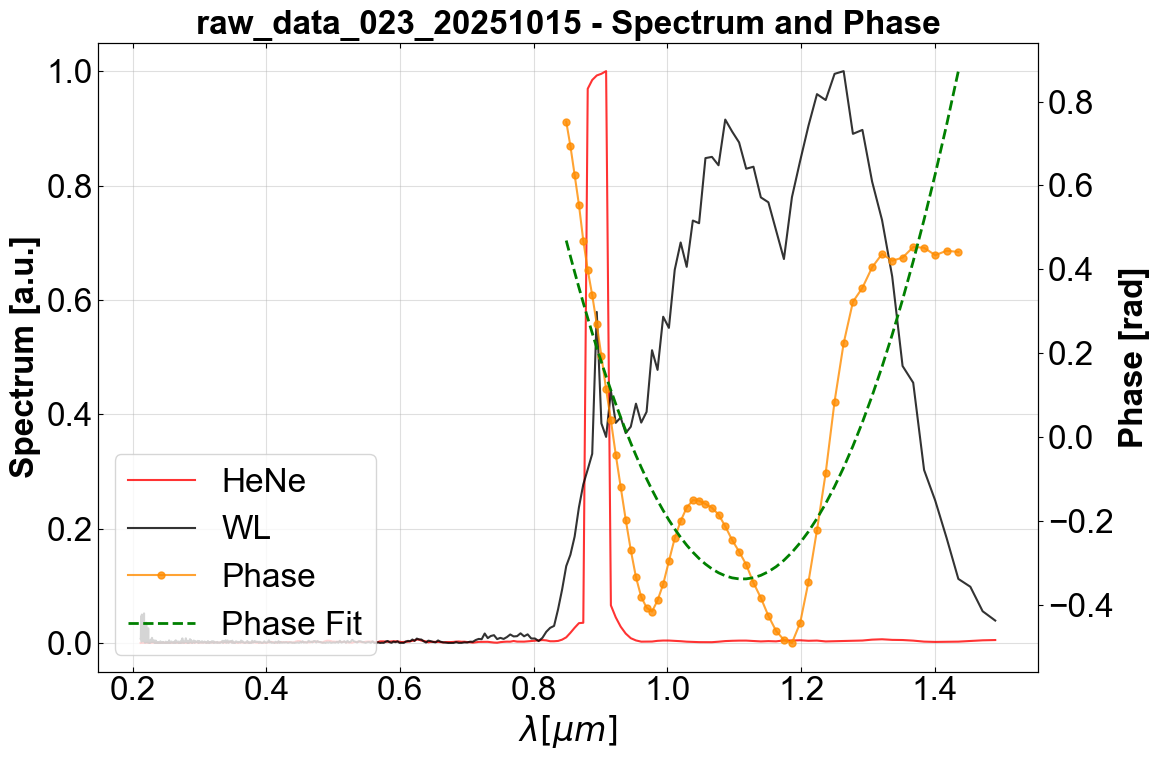


Processing: raw_data_024_20251015


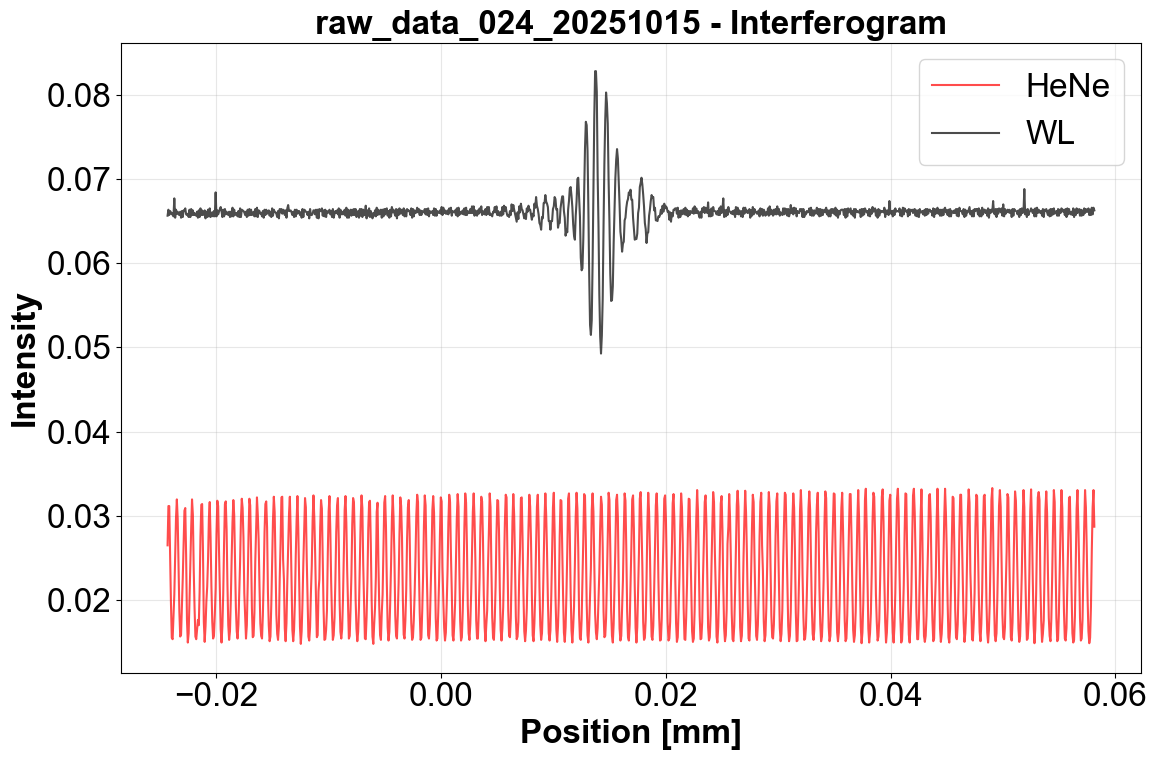

Zero delay correction: 0.023396
Polynomial coefficients: [ 19.13789787 -43.53813282  24.26861541]
Fit domain $\lambda$ = 0.887 to 1.435 $\mu m$


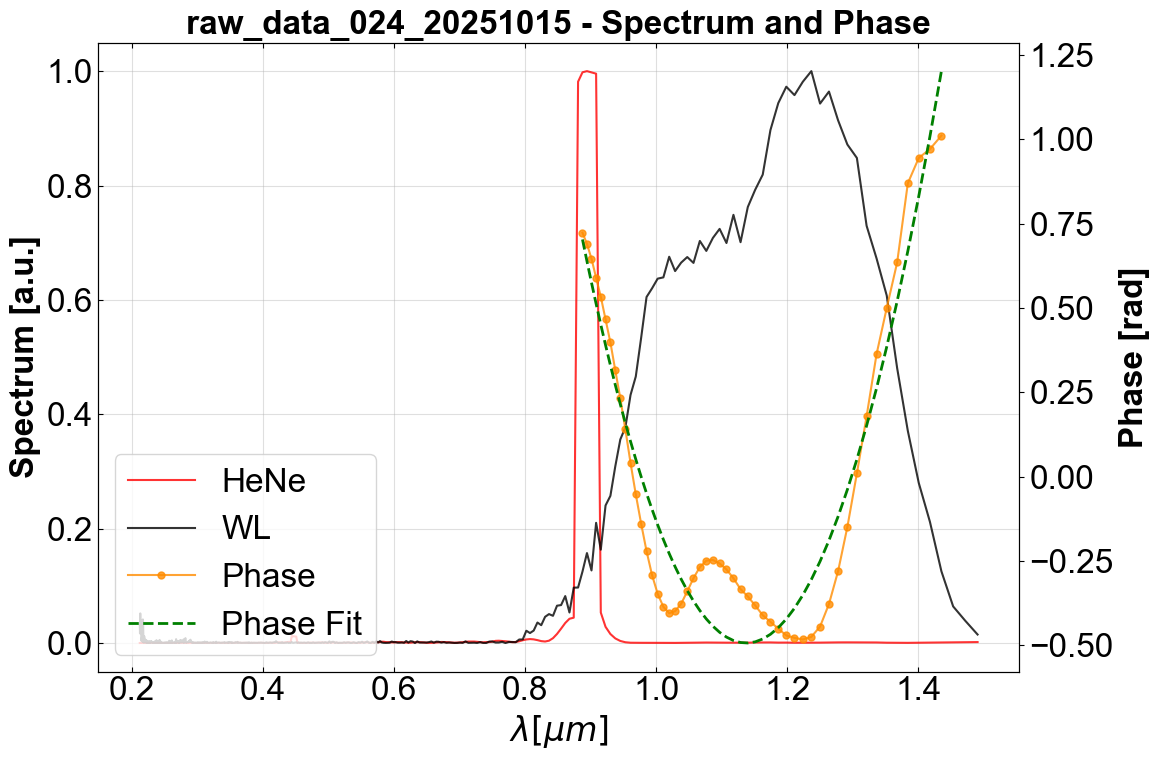


Processing: raw_data_025_20251015


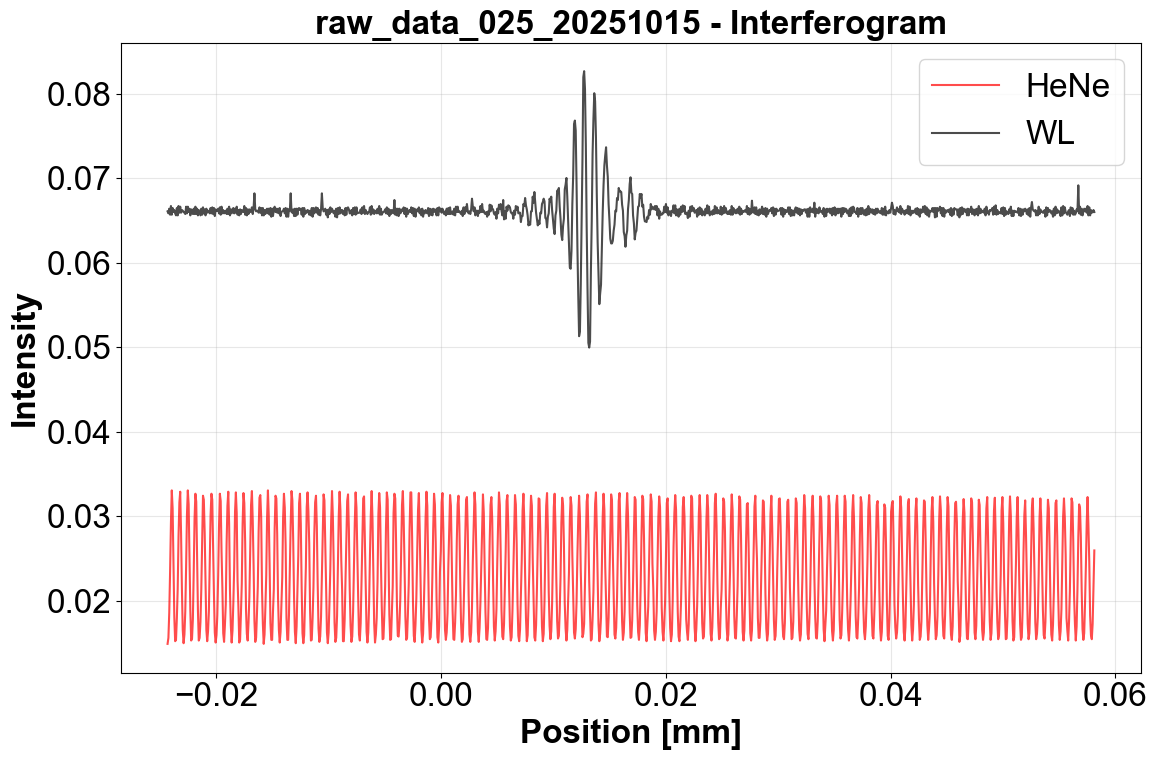

Zero delay correction: 0.022137
Polynomial coefficients: [ 15.27353324 -34.44467079  18.96696328]
Fit domain $\lambda$ = 0.861 to 1.453 $\mu m$


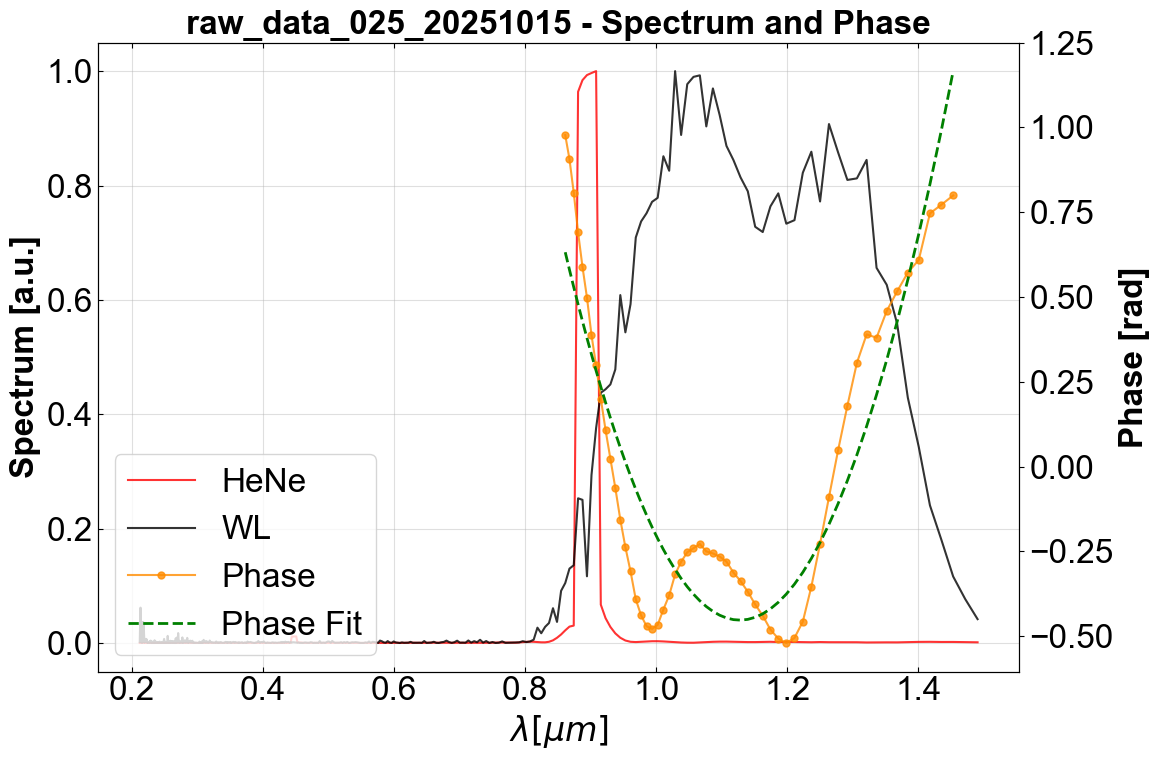



Calculating averaged spectrum and phase...
Averaged 23 datasets
Average phase polynomial coefficients: [ 10.81624859 -23.94092308  12.95955476]
Average fit domain $\lambda$ = 0.830 to 1.490 $\mu m$


/tmp/ipykernel_8083/529820559.py:180: RuntimeWarning: Mean of empty slice
  phase_avg = np.nanmean(phases_interp, axis=0)


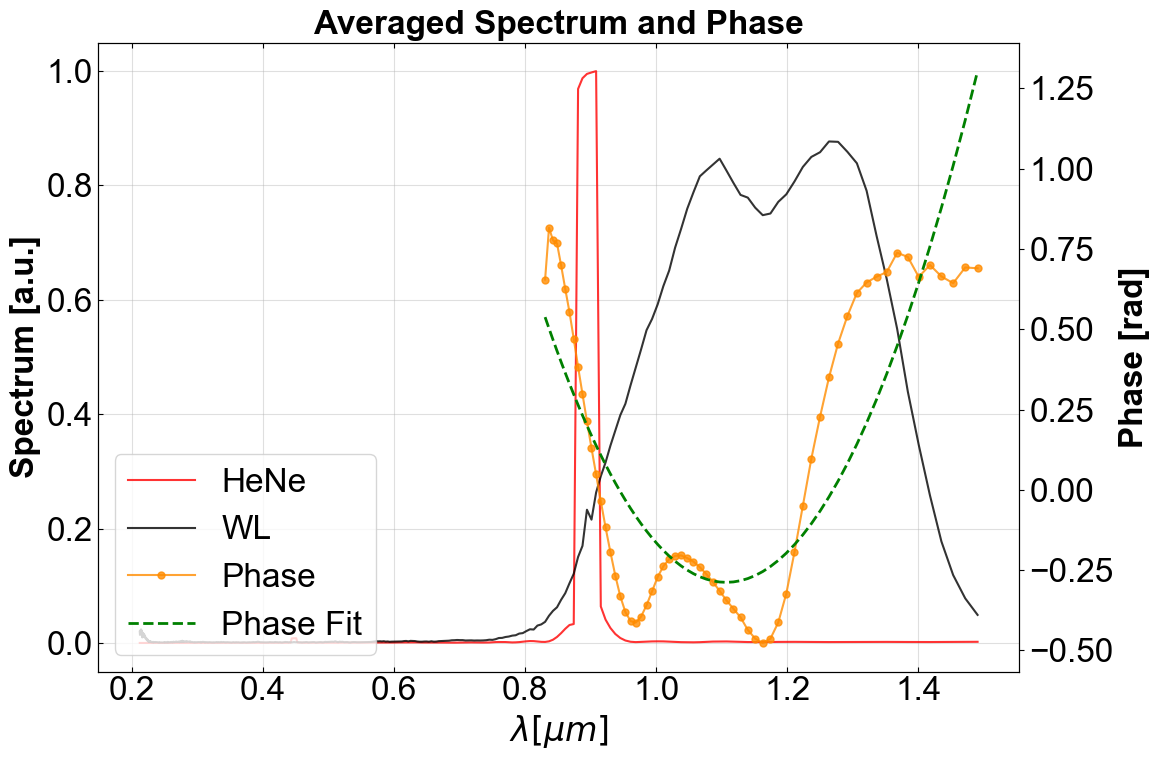

In [15]:
# Main processing script
if __name__ == '__main__':
    # Path to data
    path = '../Team32025/WLI_establish_20251015/'
    data = extract_data(path)
    
    start_idx = 700
    end_idx = 1800
    
    # Set to True to show diagnostic plots
    show_diagnostics = True

    save_figures = False
    output_dir = 'Plots/NoGlass'  # Directory to save figures

    exclude = ['raw_data_015_20251015',
          'raw_data_021_20251015']

    if save_figures:
        os.makedirs(output_dir, exist_ok=True)
    
    # Store for averaged results
    all_spectrums = []
    all_phases = []
    all_lambdas = []
    
    print(f'Processing data from index {start_idx} to {end_idx}')
    print(f'Found {len([k for k in data.keys() if k.endswith('_HN_data')])} datasets\n')
    
    # Process each dataset
    for key in sorted(data.keys()):
        if key.endswith('_HN_data'):
            base_key = key[:-8]
            wl_key = f'{base_key}_WL_data'
            meta_key = f'{base_key}_meta'
            
            if wl_key in data:
                print(f'Processing: {base_key}')

                if base_key in exclude:
                    print(f'  Skipping {base_key} (in exclusion list)')
                    print()
                    continue
                    
                # Get xLinear from metadata or create default
                if meta_key in data and 'xLinear' in data[meta_key]:
                    xL = data[meta_key]['xLinear'].flatten()
                else:
                    # Create default linear axis
                    N = len(data[key])
                    xL = np.linspace(0, 1, N)
                
                # Create data array
                dataArray = np.column_stack([data[key], data[wl_key]])

                if show_diagnostics:
                
                    if start_idx is not None and end_idx is not None:
                        dataArray_slice = dataArray[start_idx:end_idx, :]
                        xL_slice = xL[start_idx:end_idx]
                    else:
                        dataArray_slice = dataArray
                        xL_slice = xL
    
                    fig = plot_diagnostic(dataArray_slice, xL_slice, 
                                         title=f'{base_key} - Interferogram',
                                         save_fig=save_figures,
                                         output_dir=output_dir,
                                         filename=f'{base_key}_Interferogram')
                    plt.show()
                    plt.close(fig)
                # Show diagnostic plots if requested (only for first dataset for test)
                #if show_diagnostics and len(all_spectrums) == 2:
                #    # Process a portion to show diagnostics
                #    N = len(dataArray)
                #    if start_idx is not None and end_idx is not None:
                #        dataArray_slice = dataArray[start_idx:end_idx, :]
                #        xL_slice = xL[start_idx:end_idx]
                #    else:
                #        dataArray_slice = dataArray
                #        xL_slice = xL
                #
                #    
                #    # Calculate FFT for diagnostics
                #    heneData = dataArray_slice[:, 0]
                #    xNL = calibrateDelayAxis(heneData, xL_slice)
                #    f_hene = interp1d(xNL, heneData, kind='cubic', fill_value=0, bounds_error=False)
                #    f_wl = interp1d(xNL, dataArray_slice[:, 1], kind='cubic', fill_value=0, bounds_error=False)
                #    dataArray_interp = np.column_stack([f_hene(xL_slice), f_wl(xL_slice)])
                #    
                #    N_slice = len(dataArray_slice)
                #    c_mm_ps = 0.3
                #    t = 2*xL_slice/c_mm_ps
                #    dw = 2*np.pi/(np.max(np.abs(t)) - np.min(np.abs(t)))
                #    wMax = dw*N_slice
                #    w = np.linspace(-wMax/2, wMax/2, N_slice)
                #    
                #    field = dataArray_interp - dataArray_interp[N_slice//4, :]
                #    field[field < -0.03] = 0
                #    field_fft = nfft(field, axis=0)
                #    field_fft = np.fft.ifftshift(np.fft.fft(np.fft.fftshift(field, axis=0), axis=0), axis=0)
                #    
                #    lambda_vals_diag = (2*np.pi*c_mm_ps/w) * 1000
                # 
                #    plot_diagnostic(dataArray_interp, xL_slice, field_fft, w, lambda_vals_diag, 
                #                  title=f'{base_key} - Diagnostic')
                #    plt.show()
                
                # Process the data
                try:
                    xCen, spectrum, wLPhase, lambda_vals, w_vals = WLI_processData(
                        dataArray, xL, start_idx, end_idx
                    ) 
                
                    
                    # Fit phase with 2nd degree polynomial
                    coeffs, phase_fit, lambda_trim, phase_trim = fit_phase_polynomial(lambda_vals, wLPhase, degree=2)
                    
                    if coeffs is not None:
                        print(f'Zero delay correction: {xCen:.6f}')
                        print(f'Polynomial coefficients: {coeffs}')
                        print(rf'Fit domain $\lambda$ = {lambda_trim[0]:.3f} to {lambda_trim[-1]:.3f} $\mu m$')
                        
                        # Store for averaging
                        all_spectrums.append(spectrum)
                        all_phases.append(wLPhase)
                        all_lambdas.append(lambda_vals)
                        
                        # Plot
                        fig, axes = plot_spectrum_and_phase(
                            lambda_vals, spectrum, wLPhase, phase_fit, lambda_trim, phase_trim,
                            title=f"{base_key} - Spectrum and Phase",
                            save_fig=save_figures,
                            output_dir=output_dir,
                            filename=f'{base_key}_Spectrum_and_Phase')
                        plt.show()
                        plt.close(fig)
                        
                        if save_figures:
                            filename = f'{base_key}_Spectrum_and_Phase.pdf'
                            fig.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
                            print(f'  Saved: {filename}')
                        plt.show()
                    else:
                        print(f'Warning: Could not fit polynomial (not enough valid phase points)')
                    
                except Exception as e:
                    print(f'Error processing {base_key}: {str(e)}')
                
                print()
    
    # Calculate and plot averaged results
    if len(all_spectrums) > 0:
        print('\nCalculating averaged spectrum and phase...')
        
        # Make sure all have same wavelength axis (interpolate if needed)
        lambda_common = all_lambdas[0]
        
        spectrums_interp = []
        phases_interp = []
        
        for spec, phase, lam in zip(all_spectrums, all_phases, all_lambdas):
            if not np.array_equal(lam, lambda_common):
                # Interpolate to common wavelength axis
                f_spec_hene = interp1d(lam, spec[:, 0], bounds_error=False, fill_value=np.nan)
                f_spec_wl = interp1d(lam, spec[:, 1], bounds_error=False, fill_value=np.nan)
                f_phase = interp1d(lam, phase, bounds_error=False, fill_value=np.nan)
                
                spec_interp = np.column_stack([f_spec_hene(lambda_common), f_spec_wl(lambda_common)])
                phase_interp = f_phase(lambda_common)
            else:
                spec_interp = spec
                phase_interp = phase
            
            spectrums_interp.append(spec_interp)
            phases_interp.append(phase_interp)
        
        # Calculate average (ignoring NaNs)
        spectrum_avg = np.nanmean(spectrums_interp, axis=0)
        phase_avg = np.nanmean(phases_interp, axis=0)
        
        # Fit averaged phase
        coeffs_avg, phase_fit_avg, lambda_trim_avg, phase_trim_avg = fit_phase_polynomial(lambda_common, phase_avg, degree=2)
        
        print(f'Averaged {len(all_spectrums)} datasets')
        print(f'Average phase polynomial coefficients: {coeffs_avg}')
        if lambda_trim_avg is not None:
            print(rf'Average fit domain $\lambda$ = {lambda_trim_avg[0]:.3f} to {lambda_trim_avg[-1]:.3f} $\mu m$')
        
        # Plot averaged spectra and phase
        fig, axes = plot_spectrum_and_phase(
            lambda_common, spectrum_avg, phase_avg, phase_fit_avg, lambda_trim_avg, phase_trim_avg,
            title='Averaged Spectrum and Phase',
            save_fig=save_figures,
            output_dir=output_dir,
            filename='Averaged_Spectrum_and_Phase')
        plt.show()
        plt.close(fig)